# Electromiografía: Cuantificación de la fatiga muscular 
### Flores Oliva Alejandro Elliot
#### Licenciatura en Física Biomédica en Ciencias Biológicas , Facultad de Ciencias, Universidad Nacional Autónoma de México.

##### Análisis elaborado por: Noel Isaías Plascencia Díaz<sup>1</sup>, Mitsui Myrna Salgado Saito<sup>2</sup>, Ana Daniela del Río Pulido<sup>3</sup>, & Erin C. McKiernan<sup>4</sup>

<sup>1</sup> Licenciatura en Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>2</sup> Licenciatura en Ciencias de la Tierra, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>3</sup> Licenciatura en Física Biomédica, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>4</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>

## Índice:
[1. Resumen](#Resumen)

[2. Configuración/Diseño del notebook. ](#Configuración/Diseñodelnotebook)

[3. Fatiga muscular en una sola prueba.](#Fatigamuscularenunasolaprueba)

[4. Cambios en la amplitud de la señal EMG con fatiga.](#CambiosenlaamplituddelaseñalEMGconfatiga)

[5. Cambios en la frecuencia EMG con fatiga.](#CambiosenlafrecuenciaEMGconfatiga)

[6. Fatiga muscular en las pruebas.](#Fatigamuscularenlaspruebas)


<a id='Resumen'></a>
## Resumen


En este notebook se utilizaran diversas formas de visualizar y cuantificar la fatiga, conocemos que los músculos se contraen, pero también se fatigan, esta fatiga la podemos ver especialmente si se aplica una fuerza o si la contracción es prolongada. La cuantificación de la fatiga la podemos realizar mediante registros de EMG durante la contracción sostenida.

En este repositorio se extraerán y graficaron los registros de electromiografía en contracción excéntrica y concéntrica, se usaron diversos filtros como el Filtro band-pass Butterworth, rectificar la señal, cálculo de envolvente, utilizar umbrales para detectar contracciones, entre otros análisis. Todas las grabaciones de electromiografía se obtuvieron utilizando Backyard Brains EMG Spiker Box y se guardan como archivos de audio en formato .wav, utilizando el notebook de visualización y análisis/filtros podremos procesar esta señal (los registros utilizados en este notebook son del repositorio de la Dra. Erin Christy McKiernan: https://github.com/emckiernan/electrophys).

<a id='Configuración/Diseñodelnotebook'></a>
## Configuración/Diseño del notebook

Importamos los módulos de Python para trazar figuras, gráficos en el cuaderno y crear figuras con buena resolución y etiquetas grandes.

#### Librerías utilizadas 

Importamos las librerías/ módulos que nos permitirán hacer cálculos, filtrar datos, utilizar filtros, análisis, etc.

In [1]:
import math            #Permite usar funciones matemáticas definidas en el estándar de C.
import numpy as np     #Creación de vectores y matrices multidimensionales,permite usar otras funciones matemáticas.
import os              #Interfaces misceláneas del sistema operativo.
import pandas as pd    #Sirve para el manejo y análisis de estructuras de datos.
import scipy as sc     #Funciones importadas de numpy.
from scipy import signal#Herramientas de procesamiento de señales, funciones de filtrado, algoritmos de interpolación.
from scipy.fftpack import fft #Devuelve la transformada discreta de Fourier de secuencia real o compleja.
from scipy.signal import butter, lfilter, filtfilt
import wave            #El módulo proporciona una interfaz para el formato de sonido WAV.

#### Comandos para configuración de las imágenes/gráficos 

Configuramos para ver las figuras en notebook, creación de etiquetas, módulos para la creación de trazos.

In [ ]:
# Comando para ver figuras en el cuaderno Jupyter.
%matplotlib inline 

# Módulo de trazado.
import matplotlib.pyplot as plt 

# Comandos para crear figuras de alta resolución con etiquetas grandes.
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18                #Tamaño de fuente para etiquetas de figuras.
plt.rcParams['axes.titlesize'] = 20                #Tamaño de fuente para títulos de figuras.
plt.rcParams['font.size'] = 16                     #Tamaño de fuente para números de figura.
plt.rcParams['lines.linewidth'] = 1.6              #Ancho de línea para trazar

##### Extraer y graficar los datos

Las grabaciones de EMG se obtuvieron utilizando Backyard Brains EMG Spiker Box y se guardan como archivos de audio en formato .wav. Utilizando las librerías para visualizar nuestros datos, posteriormente con el uso de otros comandos almacenaremos los resultados relevantes para los cálculos/ análisis posteriores.

In [3]:
def EMG(archivo,graph):
    
    # Visualización del archivo .wav, es necesario saber la ubicación del archivo y su nombre.
    #Los archivos WAV contienen una secuencia de bits que representan los datos de audio sin procesar.
    record = wave.open(archivo)
    
    #Obtención del número de canales, frecuencia de muestreo, número de fotogramas. 
    NumCanales = record.getnchannels()      #Número de canales y retorna el número de canales de audio. 
    N= record.getnframes()                  #Número de fotogramas.
    FrecMuestreo = record.getframerate()    #Retorna la frecuencia del muestreo.
    AnchoMuestra=record.getsampwidth()      #Retorna el ancho de la muestra en bytes.
    
    #Análisis de datos del archivo .wav
    dstr = record.readframes(N * NumCanales) #Lee y retorna como máximo n cuadros de audio, como un objeto bytes.
    waveData = np.frombuffer(dstr, np.int16) #np.frombuffer es una función para crear una matriz unidimensional utilizando un búfer. 
    #El módulo de ondas "wave" proporciona una interfaz conveniente para el formato de sonido WAV. 
    
    #Imprimimos el número de canales, la frecuencia de muestreo y el ancho de muestra.
    #print('La grabación tiene %d canal(ó canales).' % (NumCanales))
    #print('La frecuencia de muestreo de la grabación es %d Hz.' % (FrecMuestreo))
    #print('La grabación tiene un ancho de muestra de %d' % (AnchoMuestra))
    
    #Calcular la ventana, se utiliza la función linspace para crear matrices con valores espaciados uniformemente, esta 
    #función utiliza una matriz con 5 valores que se encuentren entre 0 y 2.
    EMGtiempo=np.linspace(0, len(waveData)/FrecMuestreo, num=len(waveData))
    
    #Calcular la frecuencia.
    frec = 1/np.mean(np.diff(EMGtiempo))
    
    #Filtro Butterworth de paso de banda a 10-400Hz.
    b, a = butter(2, ([10, 400]/(frec/2)), btype = 'bandpass')
    dataf = filtfilt(b, a, waveData)
    
    
    #Rectificar la señal EMG filtrada.
    AbsSeñal = np.absolute(dataf)
    Abstiempo=np.linspace(0, len(AbsSeñal)/FrecMuestreo, num=len(AbsSeñal))
    
    
    #Filtro Butterworth de paso bajo para detección de envolvente.
    lowp = 8
    sfrec = FrecMuestreo
    low_pass = lowp/sfrec
    b, a = sc.signal.butter(4, low_pass, btype='lowpass')
    datafrle = filtfilt(b, a, AbsSeñal)
    
    #Guardamos los datos más relevantes en una matriz.
    SeñalRelevante={'FrecMuestreo':FrecMuestreo,\
        'waveData':waveData,\
        'EMGtiempo':EMGtiempo,\
        'frec':frec,\
        'dataf':dataf,\
        'AbsSeñal':AbsSeñal,\
        'Abstiempo':Abstiempo,\
        'datafrle':datafrle} 
    
    #Graficamos EMG.   
   
    if graph:
        
        fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (20,15))

        #Trazar datos filtrados.
        ax1.plot(EMGtiempo,dataf, 'black')
        ax1.set_title('Datos sin procesar', fontsize=20)
        ax1.set_xlim(0,max(EMGtiempo))
        ax1.set_xlabel('Tiempo (s)')
        ax1.set_ylabel('Voltaje ($\mu$V)')
        
        #Trazar datos rectificados con envolvente.
        ax2.plot(Abstiempo,datafrle*3, 'purple', linewidth=2.5)# multiplique para que encajan los datos
        ax2.plot(Abstiempo,AbsSeñal, 'gray', alpha=0.4)
        ax2.set_title('EMG rectificada con sobre', fontsize=20)
        ax2.set_xlim(0,max(EMGtiempo))
        ax2.set_xlabel('Tiempo (s)')
        ax2.set_ylabel('Voltaje ($\mu$V)')
        
        #Trazar la envolvente con umbral potencial.
        ax3.plot(Abstiempo,datafrle, 'purple')
        ax3.set_title('EMG envoltura', fontsize=20)
        ax3.set_xlim(0,max(EMGtiempo))
        ax3.set_xlabel('Tiempo (s)')

        #espaciado entre trazos
        plt.tight_layout(pad=3.0)
        
    return SeñalRelevante

<a id='Fatigamuscularenunasolaprueba'></a>
## Fatiga muscular en una sola prueba

Los músculos se caracterizan por tener actividad en forma de contracciones cada vez que hacen un ejercicio controlado o movimiento, aunque después de una actividad prolongada se fatigan, muchas actividades ameritan un esfuerzo significativo, en este apartado estudiaremos las diversas formas de visualizar y cuantificar la fatiga.

<a id='CambiosenlaamplituddelaseñalEMGconfatiga'></a>
## Cambios en la amplitud de la señal EMG con fatiga
La siguiente grabación se obtuvo del músculo bíceps mientras se realizaba una contracción concéntrica sostenida, el sujeto de prueba estaba sosteniendo un peso con el brazo doblado a 90 grados durante 50 segundos (la contracción comienza alrededor de t = 5s y termina en t = 55s).

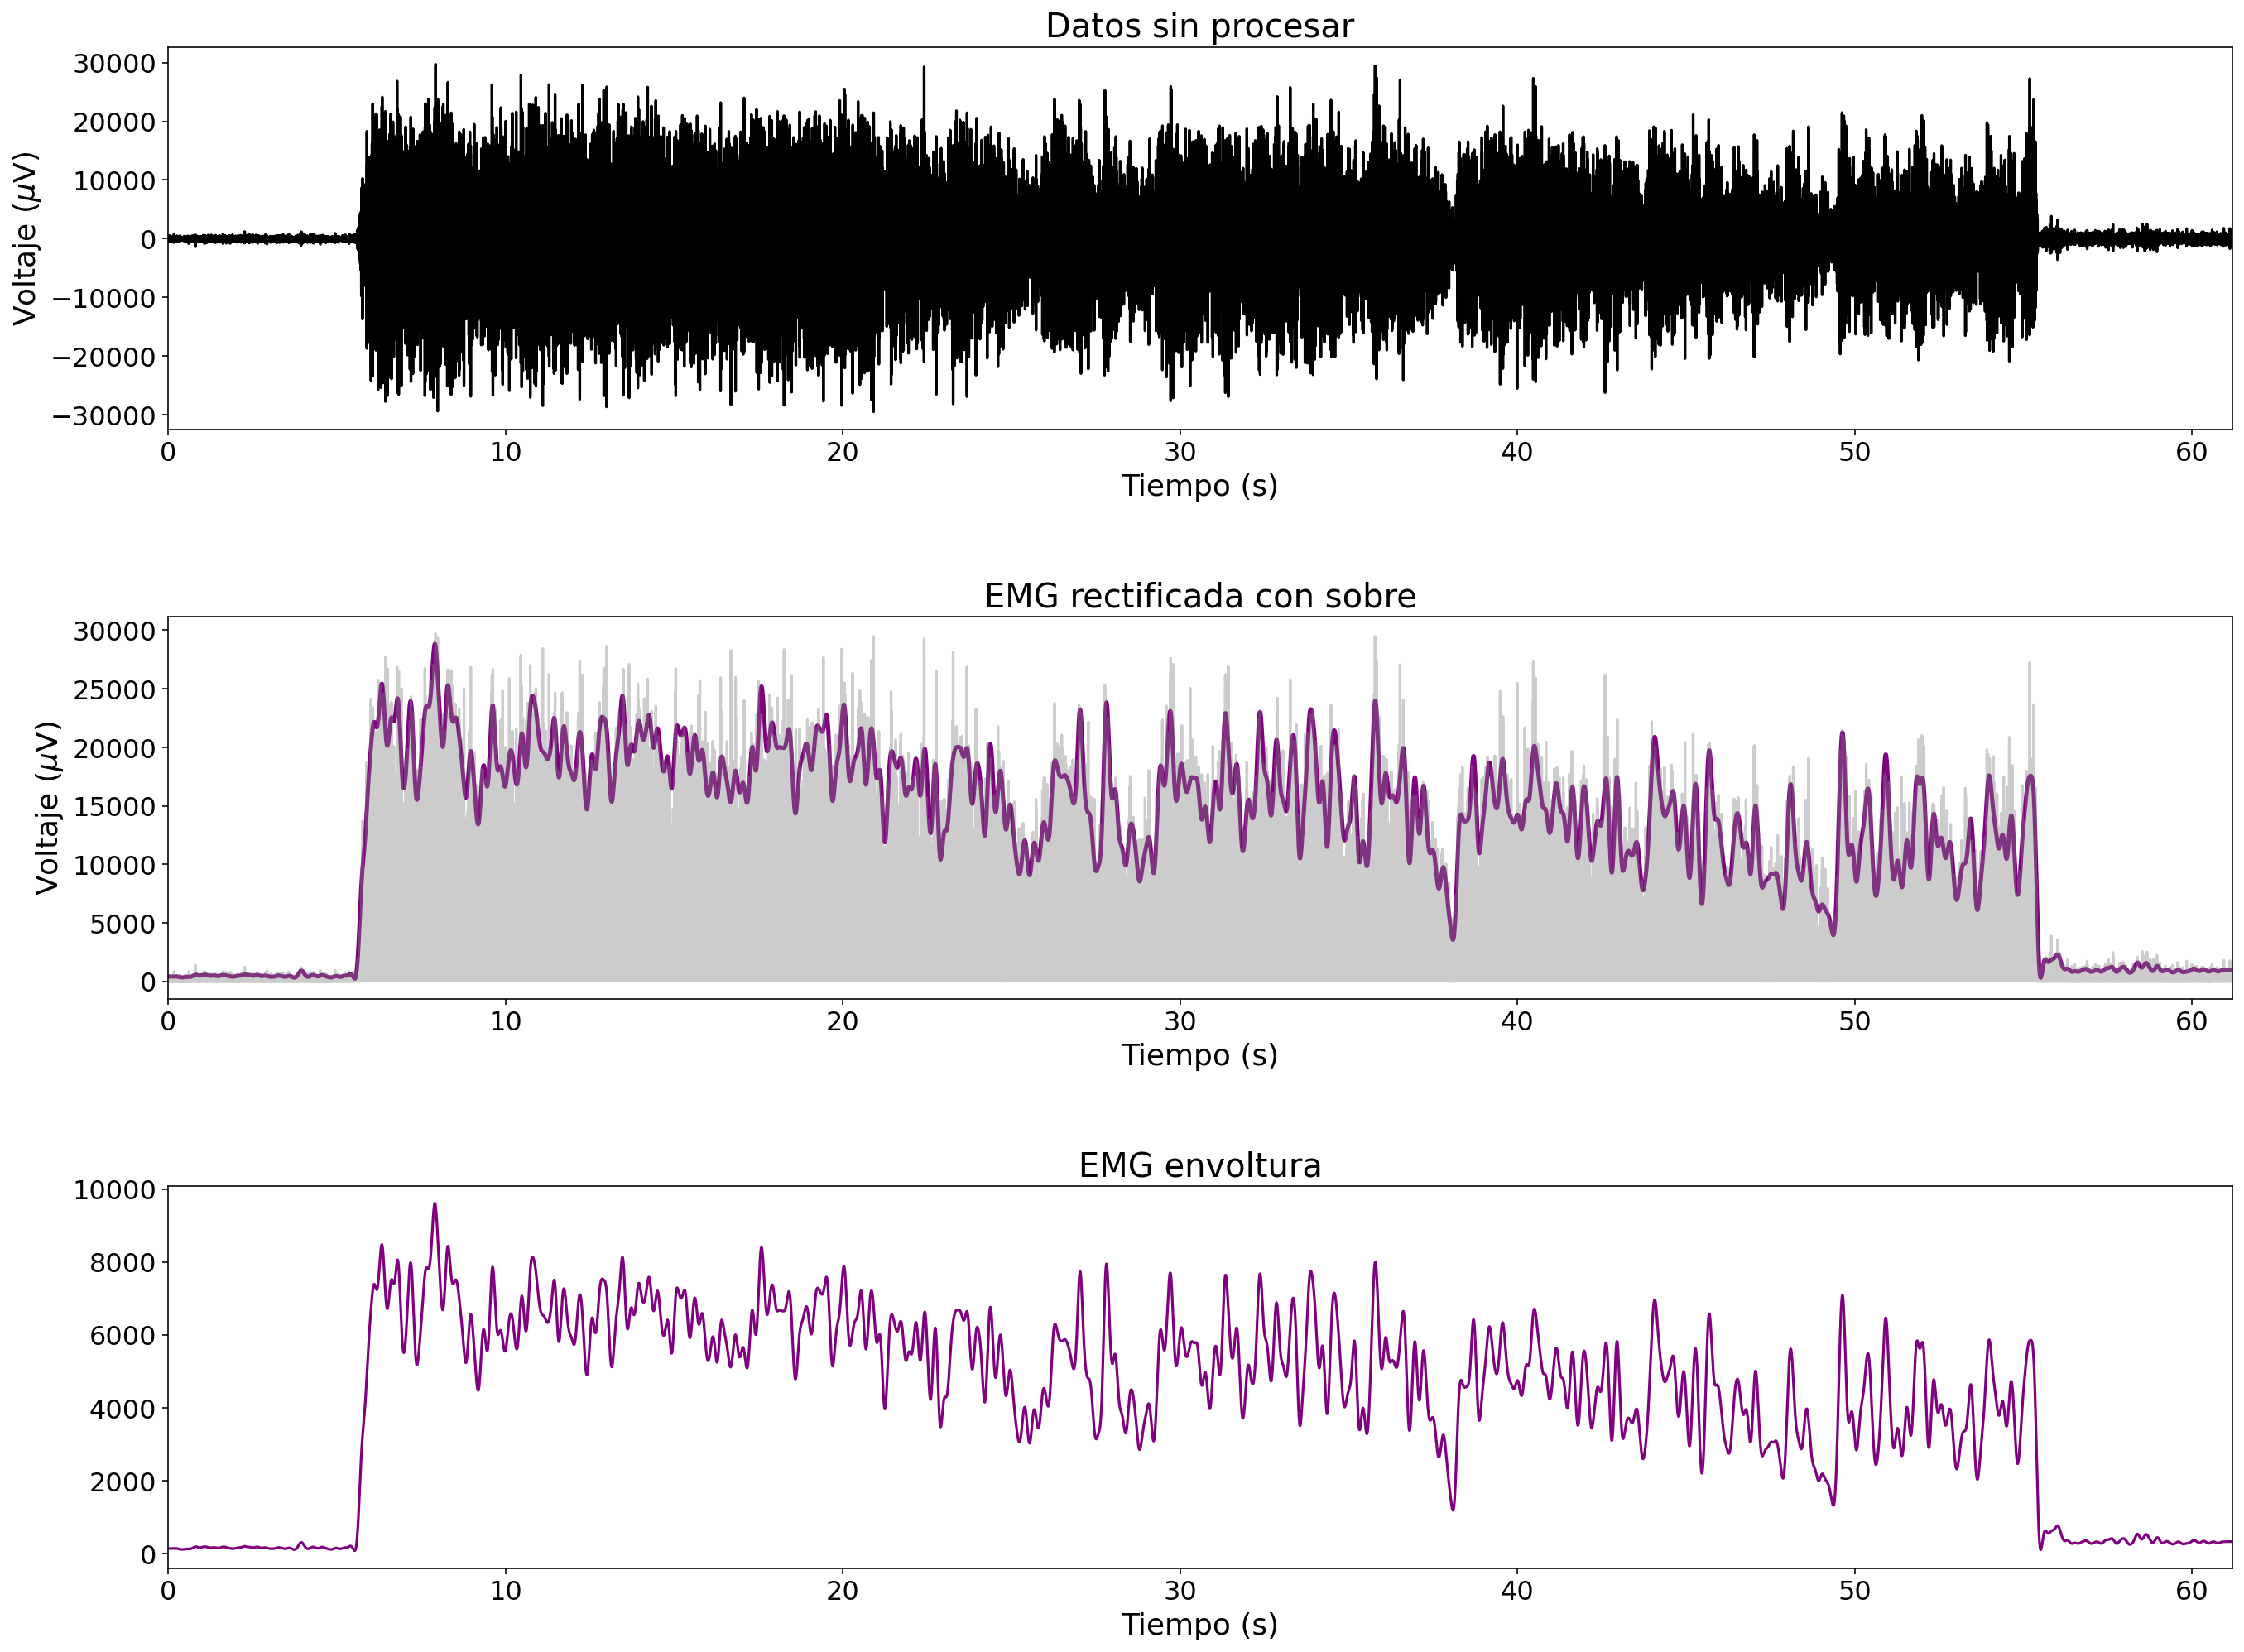

In [4]:
SeñalRelevante = EMG(archivo='../Registros/S3/concentric/S3_EMG_concentric_trial0.wav',graph=1)

Como podemos ver en la grabación anterior, la amplitud de la señal disminuye a medida que avanza la grabación y el músculo presumiblemente se fatiga. Una forma de cuantificar esto es agrupar los datos y encontrar la amplitud máxima de la señal dentro de cada intervalo. Para mayor facilidad, primero dividimos los datos en bins de 1 segundo.

In [5]:
#Calcular el número de bins de 1 segundo en la grabación; 'floor' para expresar el número como entero.
nbins = math.floor(len(SeñalRelevante['waveData'])/SeñalRelevante['FrecMuestreo'])
print('La grabación tiene % d bins de 1 segundo de duración.' % (nbins))

# función para crear contenedores, adaptada de https://www.python-course.eu/pandas_python_binning.php
def createBins(lower_bound, width, quantity):
    bins = []
    for low in range(lower_bound,lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

# ejecutar función para crear contenedores.
secBins = createBins(0,SeñalRelevante['FrecMuestreo'],nbins)


A continuación, iteramos sobre los contenedores, calculamos la amplitud máxima para cada contenedor y graficamos los resultados.


La grabación tiene  61 bins de 1 segundo de duración.


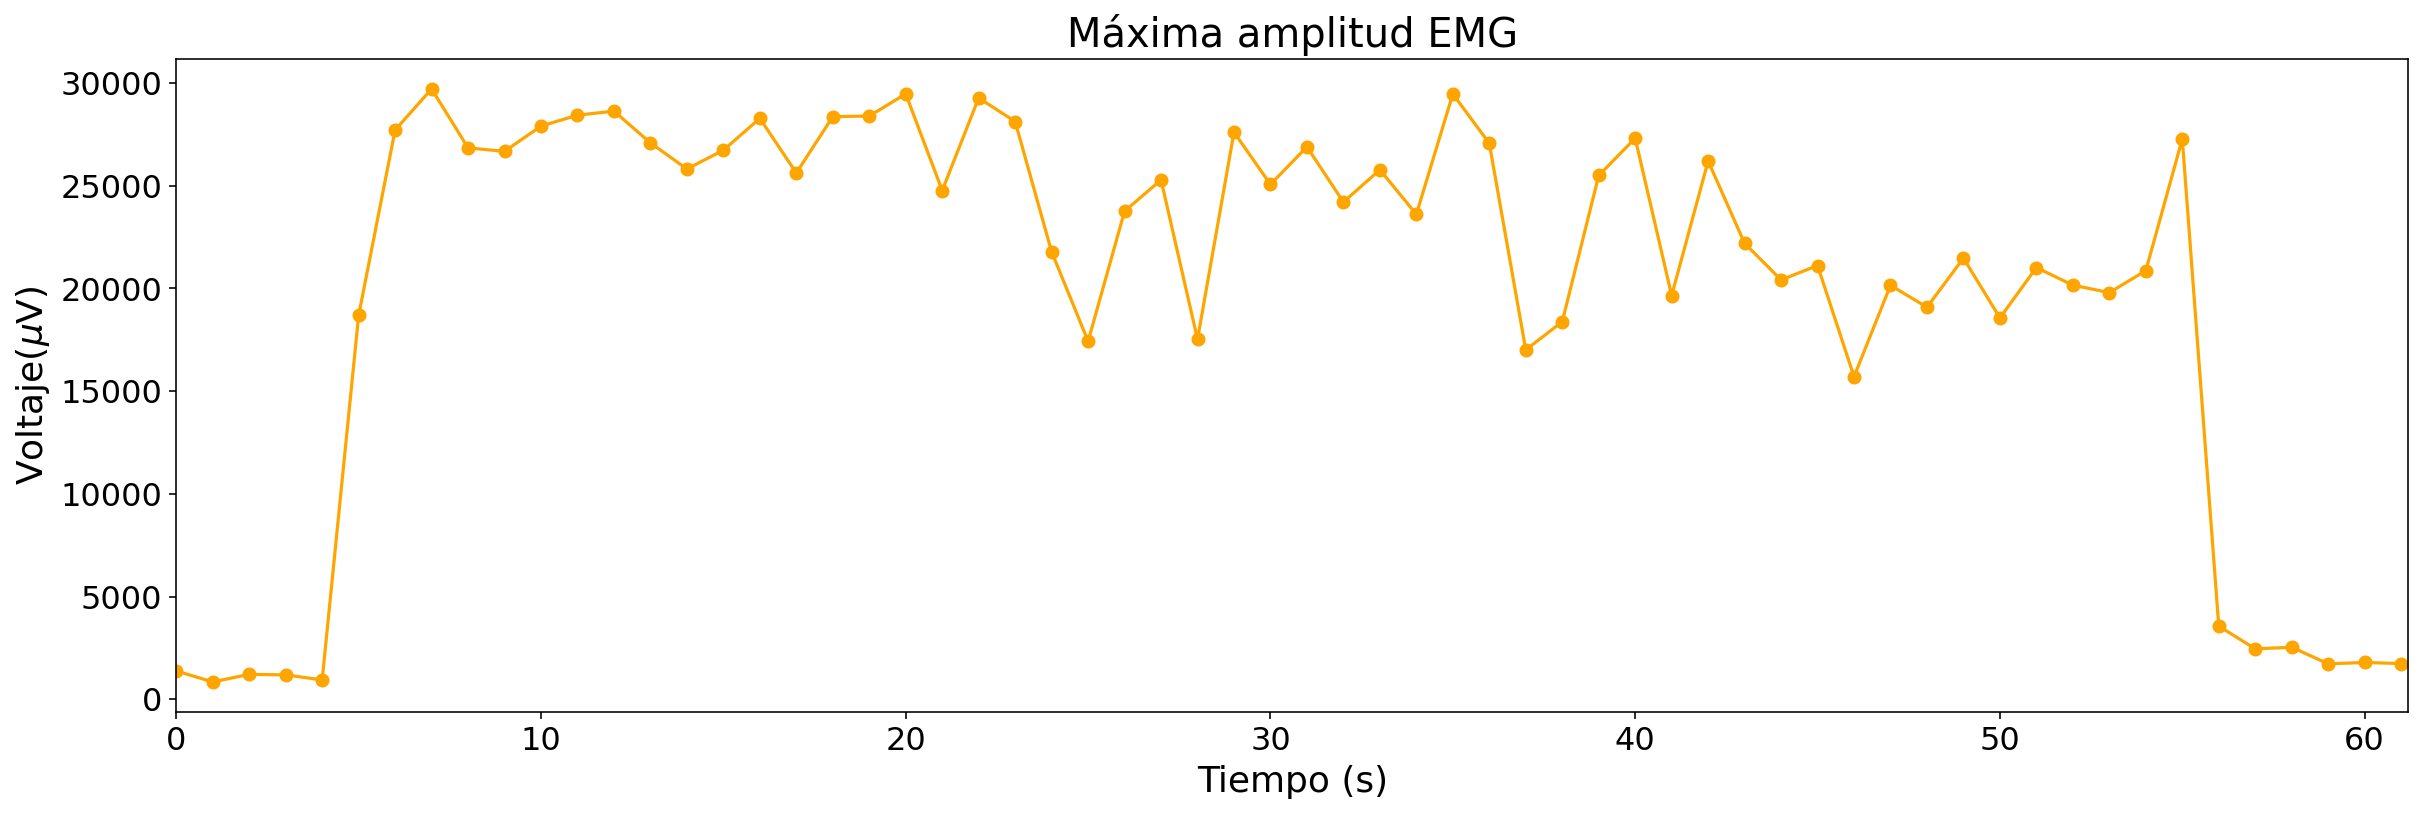

In [6]:
# Calcular la amplitud máxima sobre los contenedores
x = secBins
y = SeñalRelevante['AbsSeñal']
maxamps = []

for n in range(0,len(x)):
    maxAmp=y[min(x[n]):max(x[n])].max()
    maxamps.append(maxAmp)

# Trazamos los resultados    
plt.figure(figsize=(20,6))
plt.plot(maxamps,'o-',color='orange')
plt.title('Máxima amplitud EMG')
plt.xlabel('Tiempo (s)')
plt.xlim(0,max(SeñalRelevante['EMGtiempo']))  
plt.ylabel('Voltaje($\mu$V)');

El gráfico anterior muestra que la amplitud máxima disminuye a medida que avanza la grabación. Sin embargo, los valores atípicos hacen que la tendencia sea menos clara de lo que podría ser. En cambio, también podemos iterar sobre los contenedores y calcular la amplitud media para ver si eso nos da una imagen más clara de la disminución debido a la fatiga.

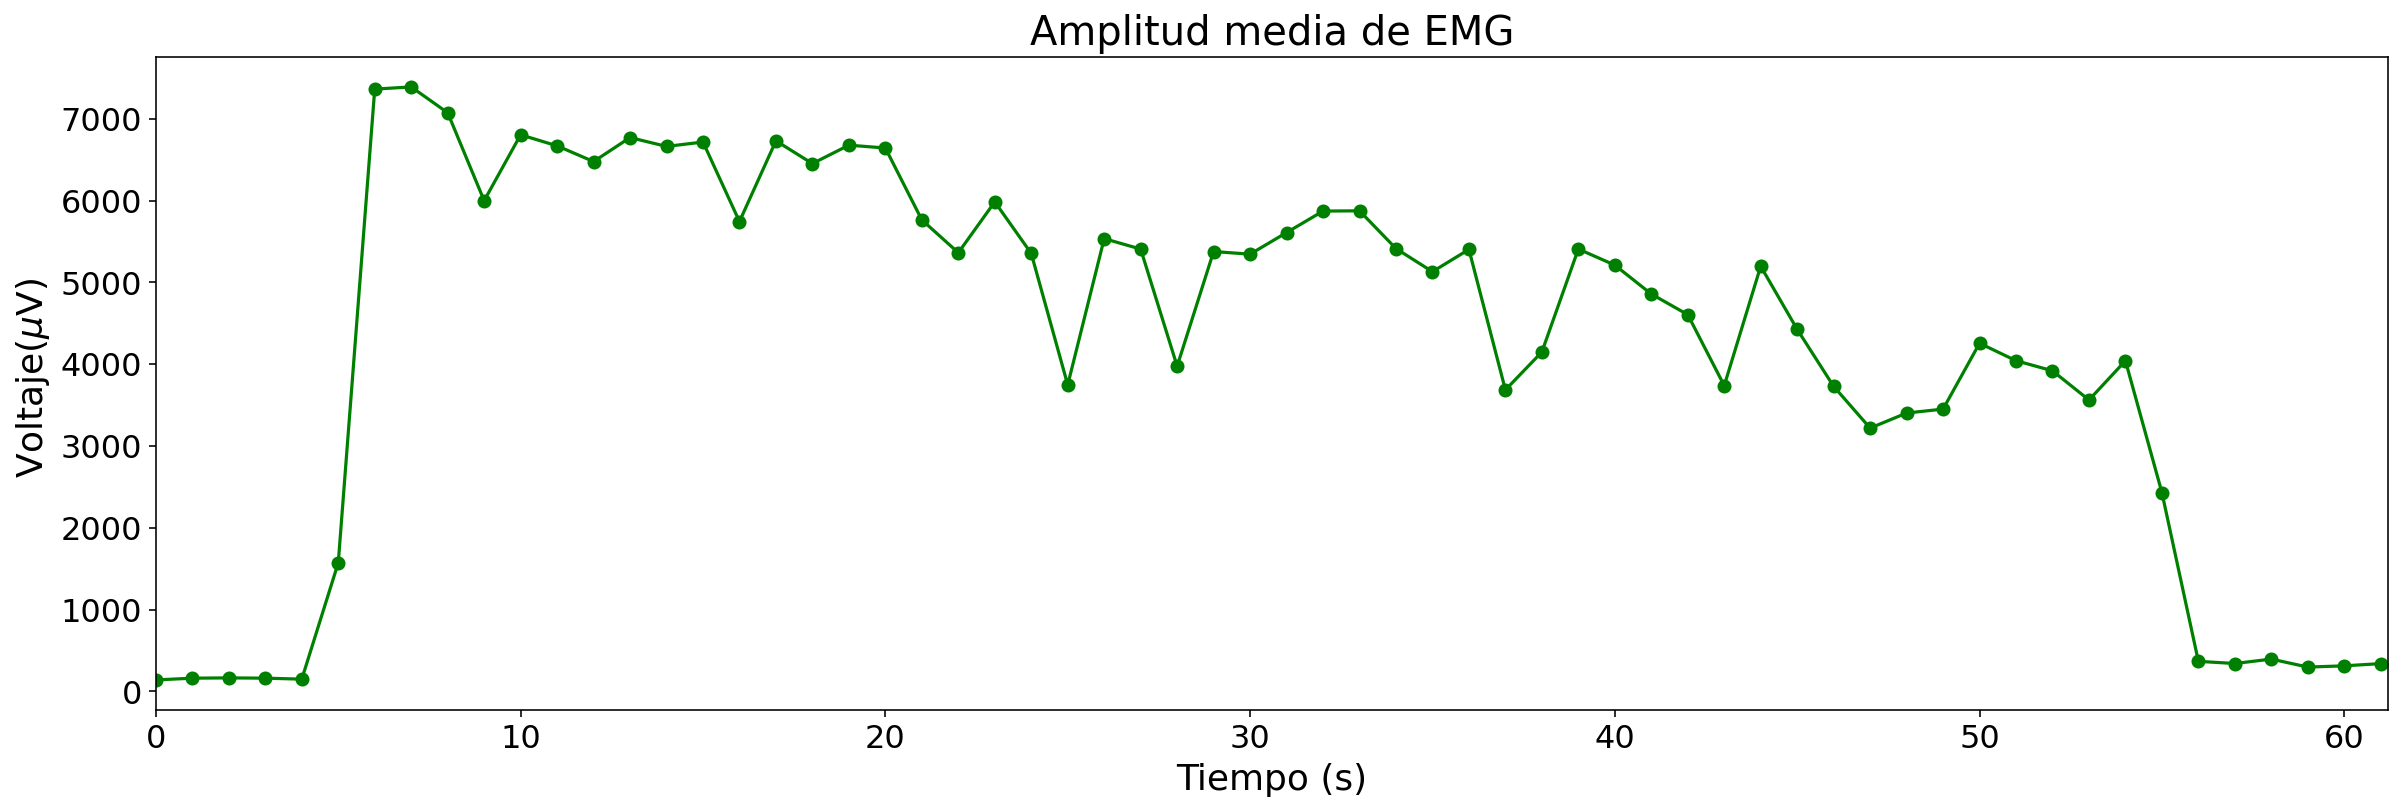

In [7]:
#Calculo de la amplitud media de los contenedores
meanamps = []
for n in range(0,len(x)):
    meanAmp=y[min(x[n]):max(x[n])].mean()
    meanamps.append(meanAmp)

# Trazamos los resultados 
plt.figure(figsize=(20,6))
plt.plot(meanamps,'o-', color='green')
plt.title('Amplitud media de EMG')
plt.xlabel('Tiempo (s)')
plt.xlim(0,max(SeñalRelevante['EMGtiempo']))  
plt.ylabel(' Voltaje($\mu$V)');

En la gráfica anterior la tendencia observamos que la amplitud media disminuye a lo largo del registro, indicando fatiga muscular. Una forma tosca pero eficaz de calcular el tamaño de la disminución es tomando la diferencia entre las amplitudes medias máximas al principio (intervalo 6) y al final (intervalo 54) de la actividad muscular.

In [8]:
ampChange = meanamps[6] - meanamps[54]
print(ampChange)

3321.231964621004


El cálculo anterior muestra una disminución de amplitud de más de 3000 microvoltios durante el transcurso de la grabación.

También podemos calcular la varianza sobre los contenedores, lo que también indica fatiga.


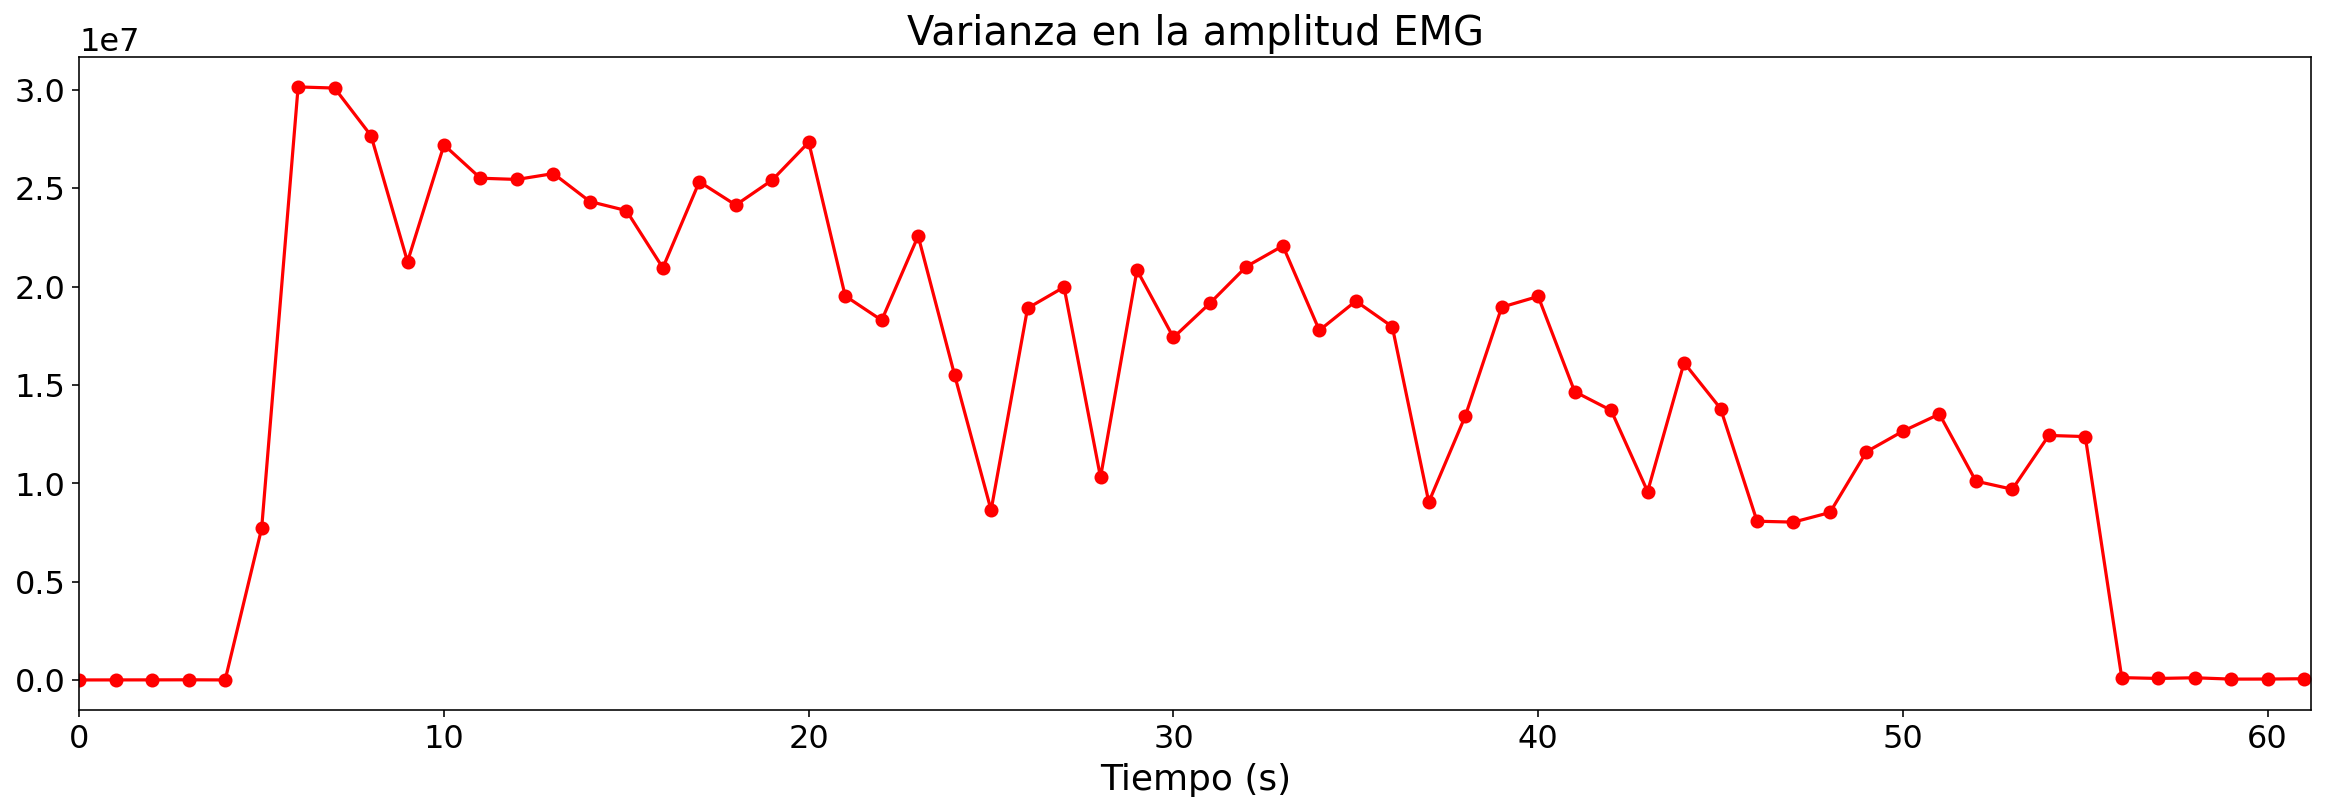

In [9]:
varamps = []
for n in range(0,len(x)):
    varAmp=y[min(x[n]):max(x[n])].var()
    varamps.append(varAmp)

# Trazamos los resultados
plt.figure(figsize=(20,6))
plt.plot(varamps,'o-',color='red')
plt.title('Varianza en la amplitud EMG')
plt.xlabel('Tiempo (s)')
plt.xlim(0,max(SeñalRelevante['EMGtiempo']));

<a id='CambiosenlafrecuenciaEMGconfatiga'></a>
## Cambios en la frecuencia EMG con fatiga

La fatiga muscular también está marcada por una disminución en la frecuencia de la señal EMG, que puede resultar tanto de una disminución en la velocidad de disparo de las unidades motoras individuales como de una disminución en el número total de unidades motoras activas. 

Para facilitar el análisis, primero acortamos la señal EMG eliminando la actividad inicial antes y después de la contracción muscular. En otras palabras, el EMG acortado solo tiene la actividad durante la contracción.


In [10]:
# acortar la EMG para dejar solo la actividad de contracción; ejecutar en datos filtrados (no rectificados).
def shortEMG(signal, threshold):
    difSignal = np.diff(signal)
    startind=np.where(difSignal>threshold)[0][0]
    endind=np.where(difSignal[::-1]>threshold)[0][0]
    endind=len(difSignal)-endind
    return(signal[startind:endind])

workdata = shortEMG(SeñalRelevante['dataf'],150)

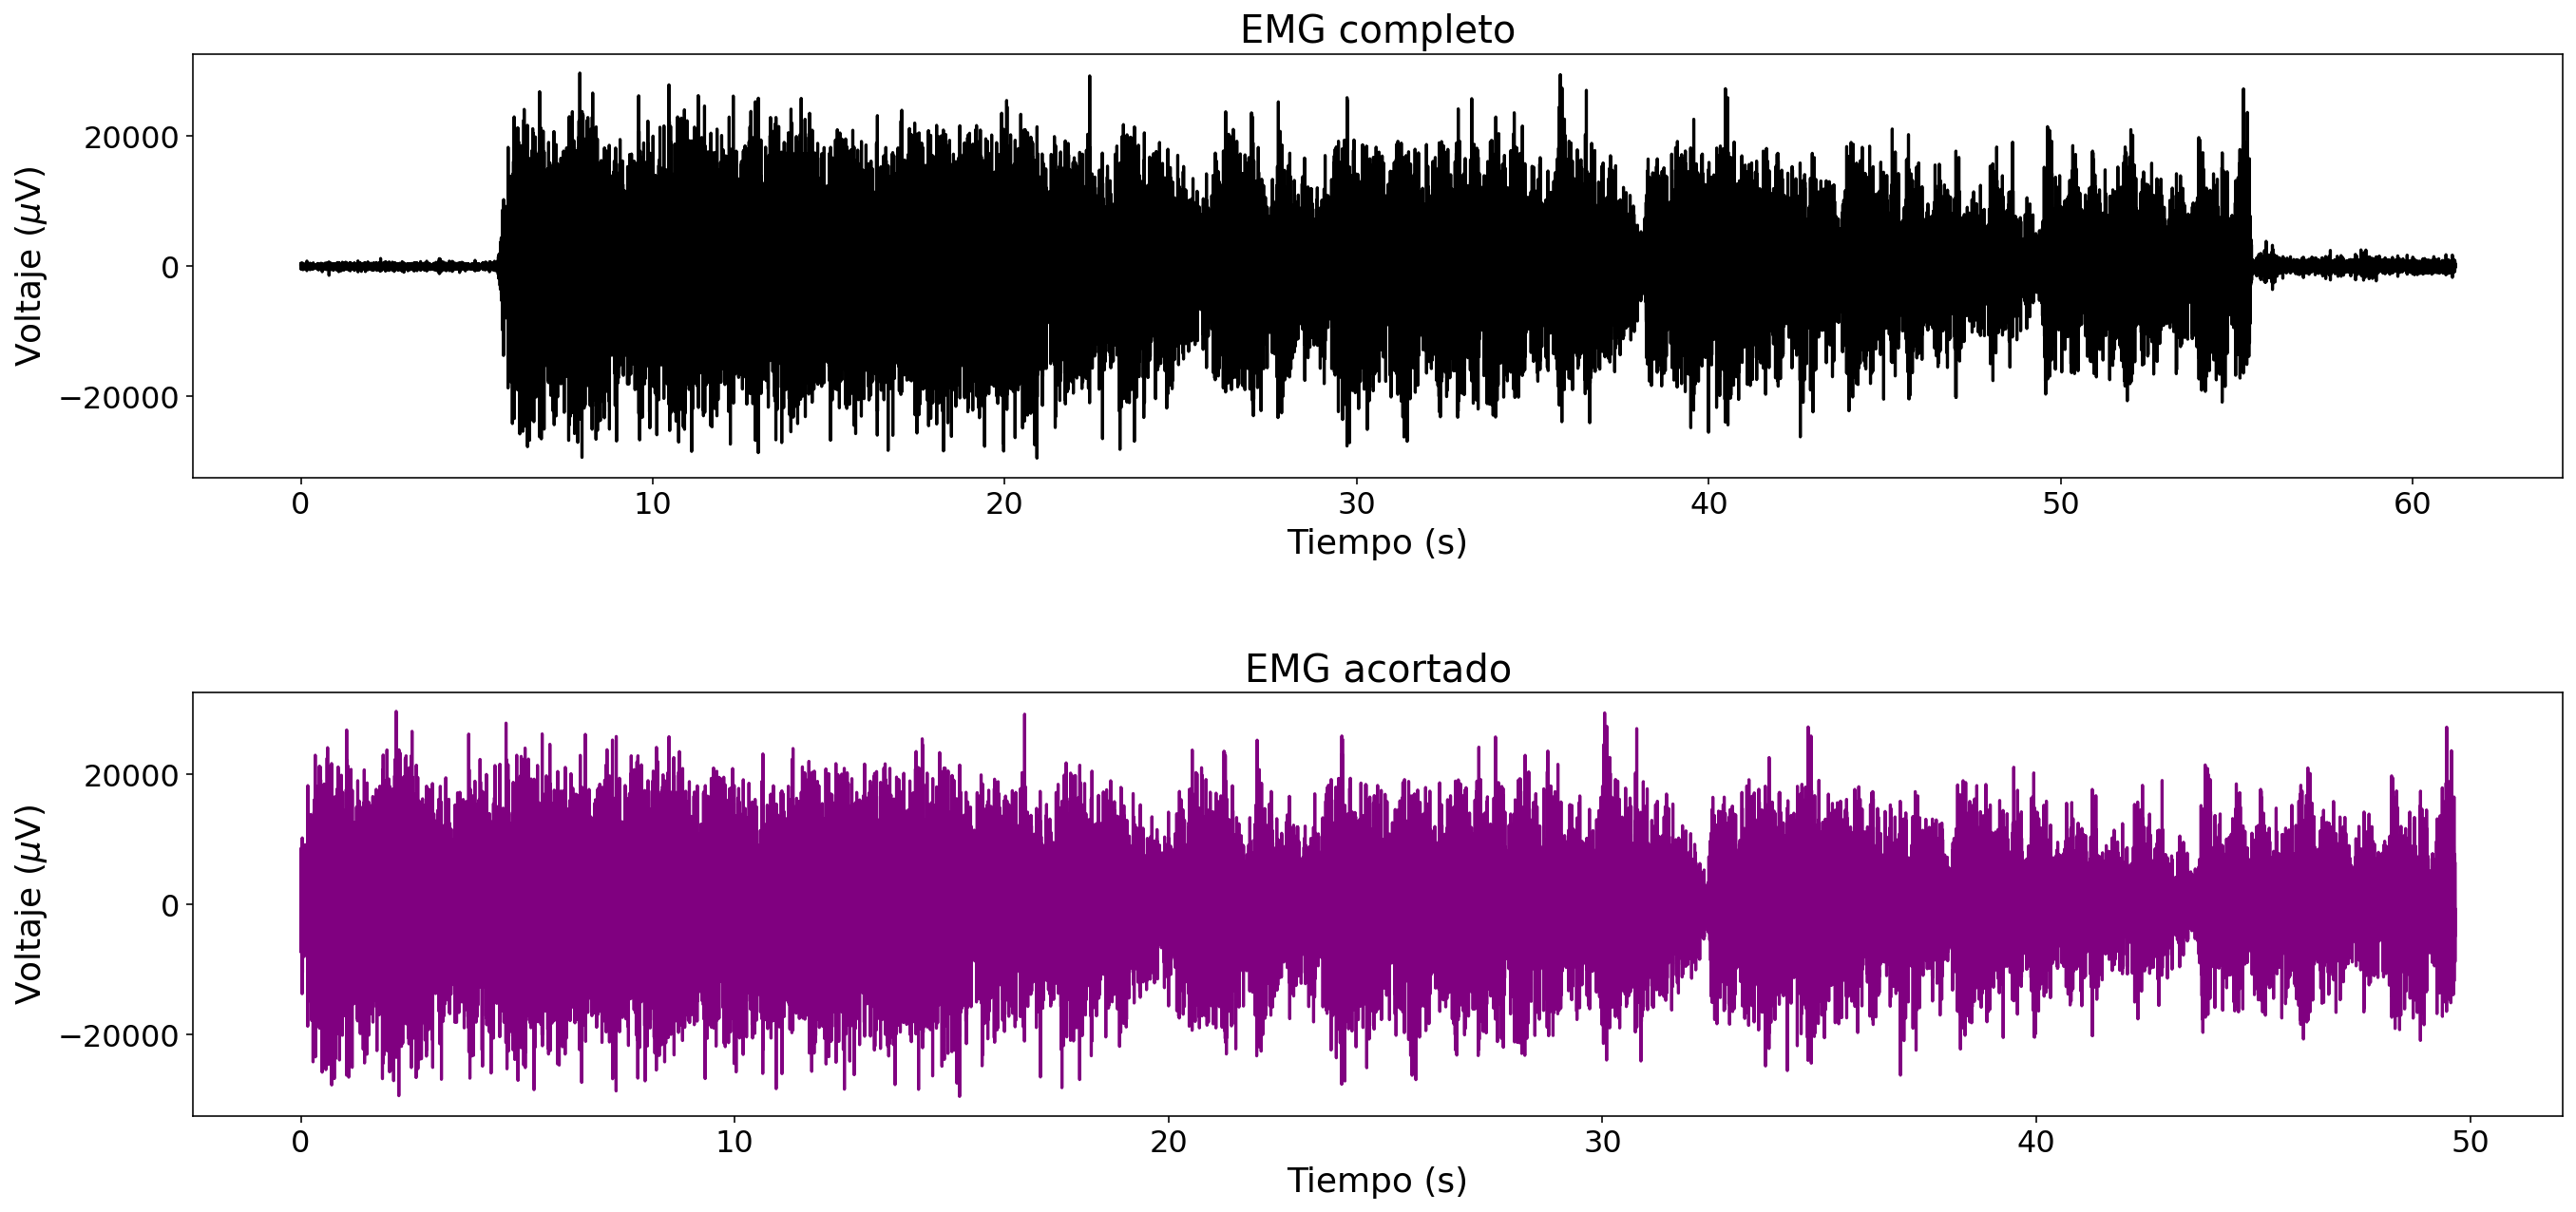

In [11]:
# trazar resultados para comparar el EMG original con el EMG acortado.
fig, (ax1,ax2) = plt.subplots(2,1,sharex=False,sharey=False,figsize = (20,10))

# EMG completo
ax1.plot(SeñalRelevante['EMGtiempo'],SeñalRelevante['dataf'],color='black')
ax1.set_title('EMG completo')
ax1.set_ylabel('Voltaje ($\mu$V)')
ax1.set_xlabel('Tiempo (s)')

# EMG acortado
ax2.plot(np.arange(0,len(workdata))/SeñalRelevante['FrecMuestreo'],workdata,color='purple')
ax2.set_title('EMG acortado')
ax2.set_ylabel(r'Voltaje ($\mu$V)')
ax2.set_xlabel('Tiempo (s)')

# Espaciado entre parcelas
plt.tight_layout(pad=3.0)

Dividimos los datos de EMG en ventanas y los definimos como los 'workdata' que ejecutaremos a través del análisis de frecuencia.


In [12]:
def windows(data,npoints,step):
    datapts = np.size(data)
    anchorpts = np.arange(0,datapts-npoints,step)
    noverlap = len(anchorpts) 
    ovData = [data[anchorpts[i]:anchorpts[i]+npoints] for i in range(0,noverlap)]    
    return(ovData)

windowedEMG = windows(workdata,SeñalRelevante['FrecMuestreo'],SeñalRelevante['FrecMuestreo'])

Calculamos la densidad espectral de potencia (PSD) usando una transformada de Fourier.

In [13]:
# Función para calcular la densidad espectral de potencia (PSD)
# adaptado de https://stackoverflow.com/questions/1523814/
# units-of-a-fourier-transform-fft-when-doing-spectral-analysis-of-a-signal/1524535

def PSD(data):
    ps = np.abs(np.fft.fft(data))**2
    timeStep = 1 / SeñalRelevante['FrecMuestreo']
    freqs = np.fft.fftfreq(data.size, timeStep)
    idx = np.argsort(freqs)
    goodinds = np.where(freqs[idx]>0)[0]
    F = freqs[idx][goodinds]
    P = ps[idx][goodinds]
    return([F,P])

F,P = PSD(windowedEMG[0])

Trazamos los resultados, mostrando la señal EMG en el primer contenedor (contenedor 0), la PSD para ese contenedor y el logaritmo de la PSD para el mismo contenedor.

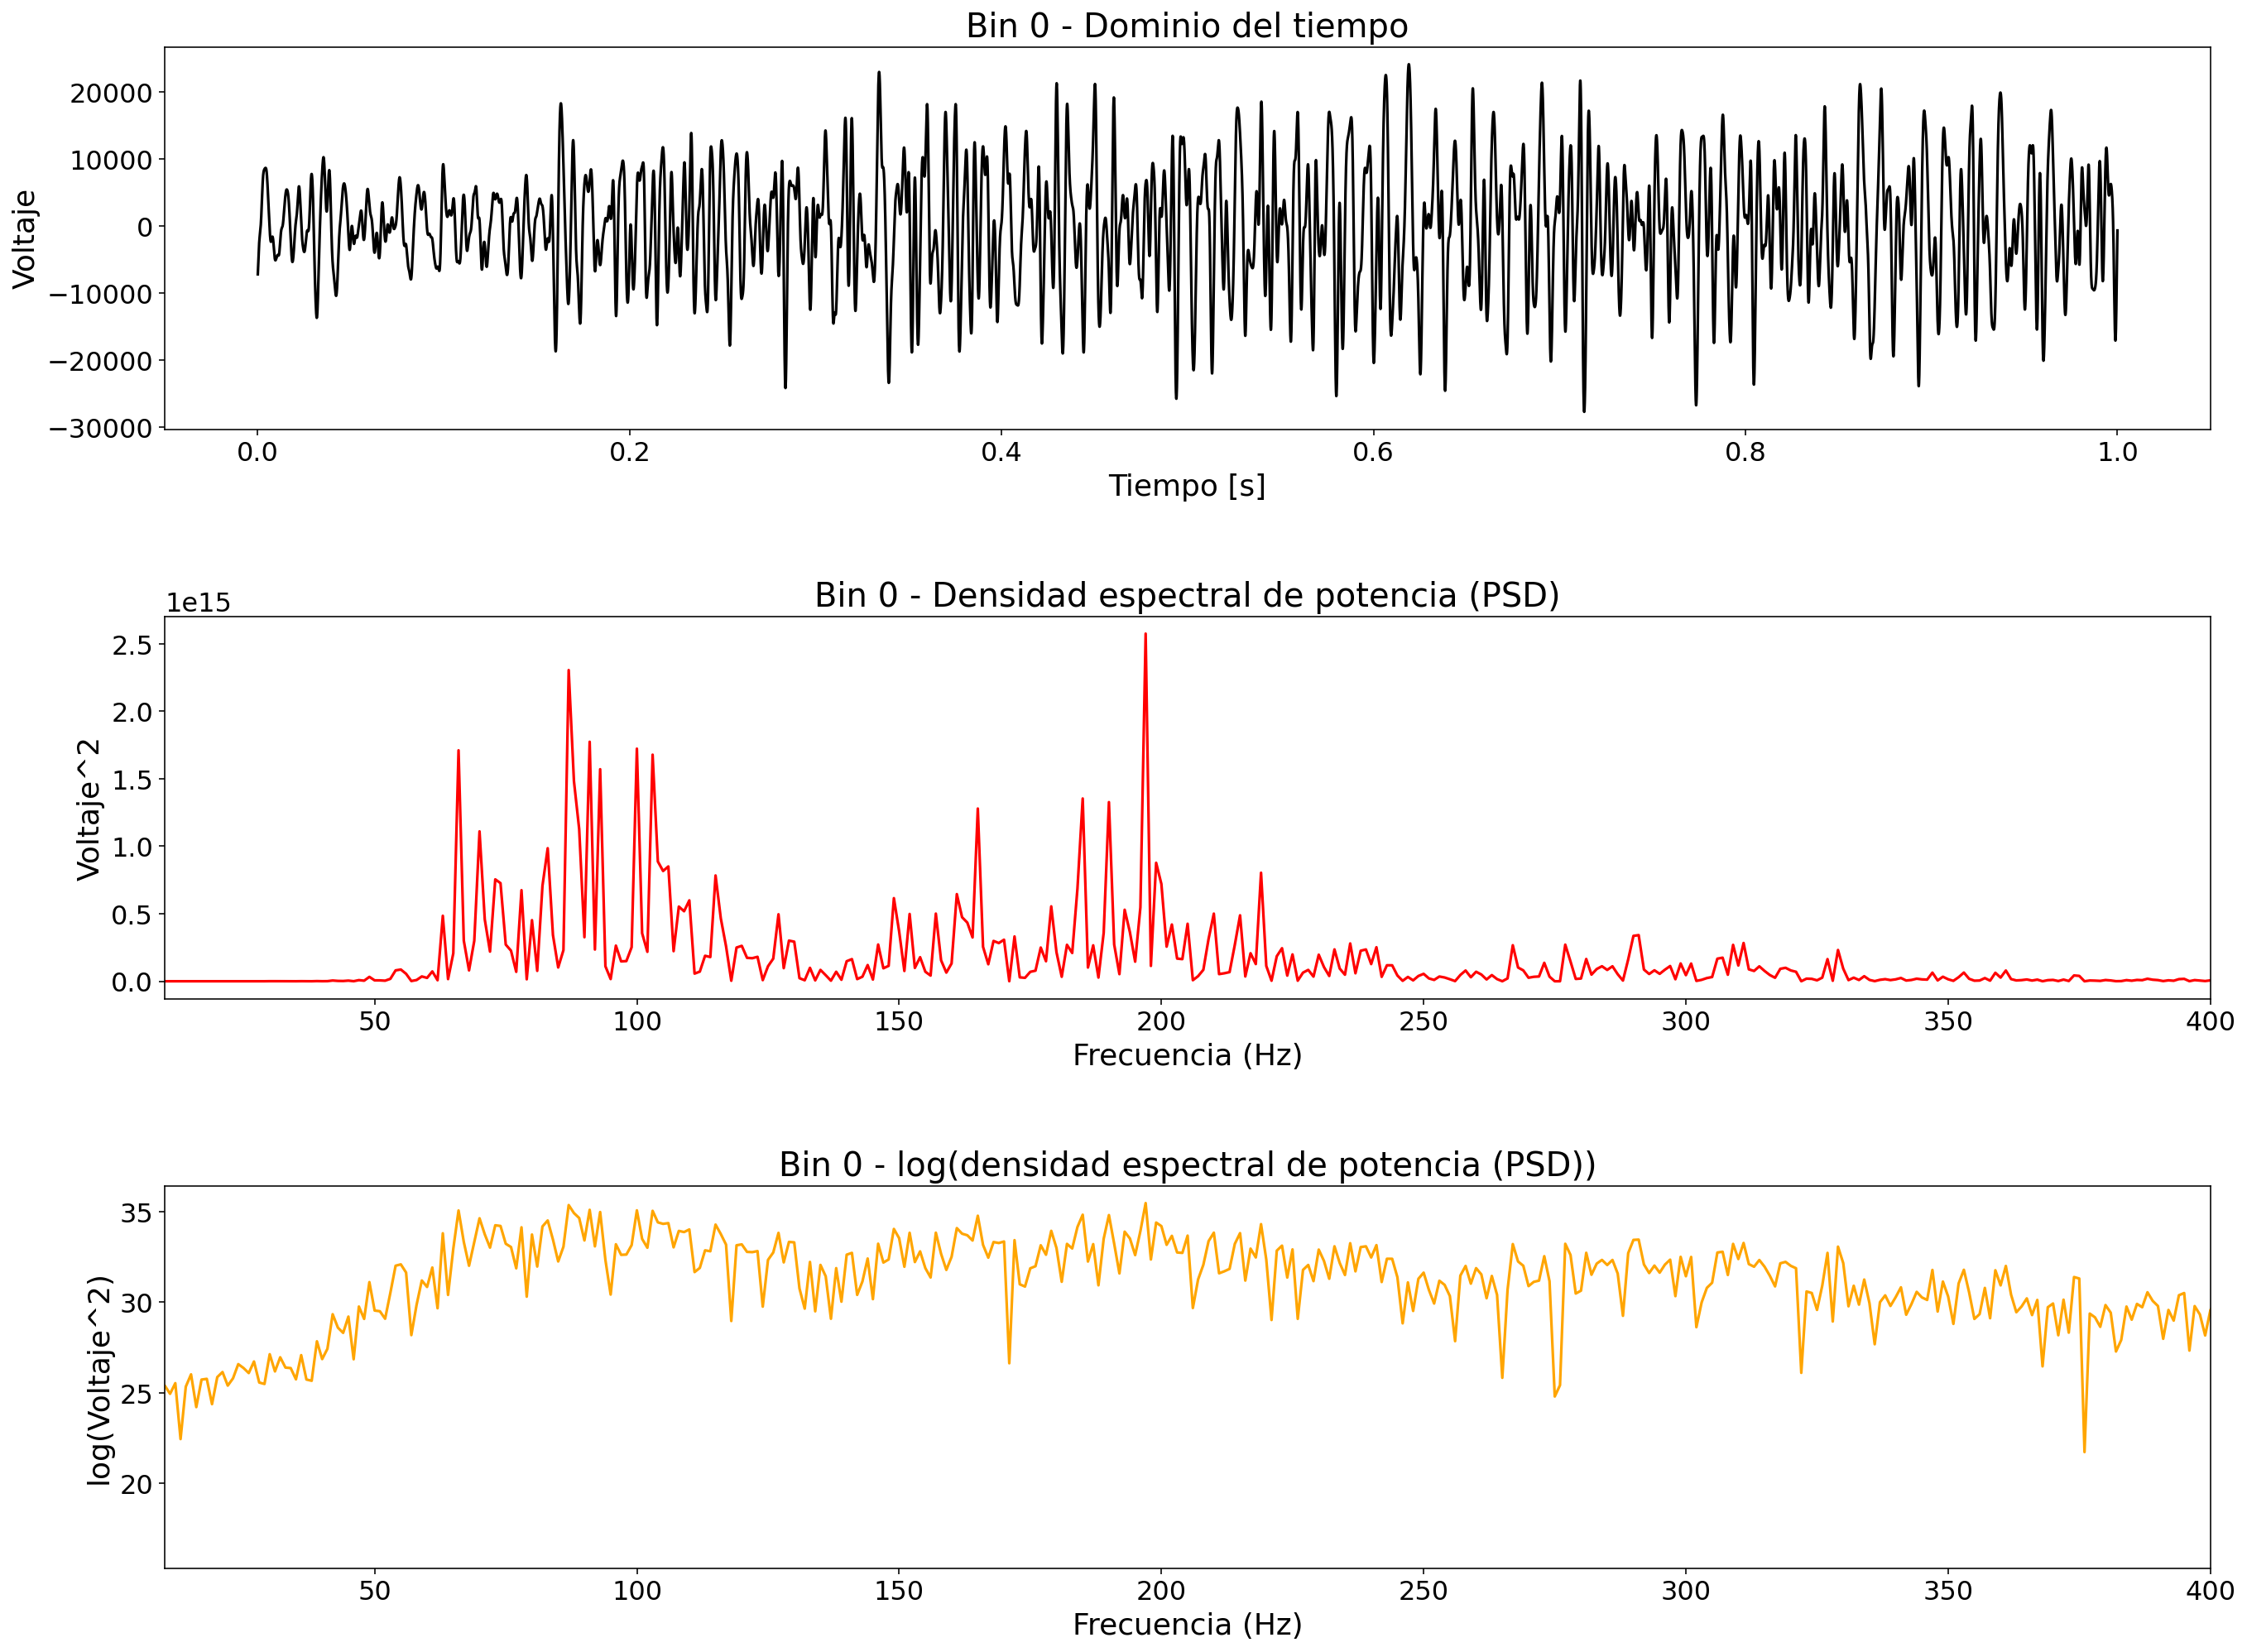

In [14]:
fig = plt.figure(figsize=(20,15))

#Señal EMG
ax = plt.subplot(311)
ax.plot(np.arange(0,SeñalRelevante['FrecMuestreo'])/SeñalRelevante['FrecMuestreo'],windowedEMG[0],color='black')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje')
plt.title('Bin 0 - Dominio del tiempo')

# la densidad espectral de potencia (PSD)
ax = plt.subplot(312)
ax.plot(F,P,color='red')
plt.xlim(10,400)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Voltaje^2') 
plt.title('Bin 0 - Densidad espectral de potencia (PSD)')

# logaritmo de la densidad espectral de potencia (PSD)
ax = plt.subplot(313)
ax.plot(F,np.log(P),color='orange')
plt.xlim(10,400)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('log(Voltaje^2)') 
plt.title('Bin 0 - log(densidad espectral de potencia (PSD))')

# Espaciado entre parcelas
plt.tight_layout(pad=3.0)

Los gráficos anteriores muestran el análisis de frecuencia solo para el primer intervalo. 

Para examinar los efectos de la fatiga, podemos comparar la primer ventana, la segunda  ventana número 10 y la última ventana de la grabación para ver cómo cambia la densidad espectral de potencia (PSD).

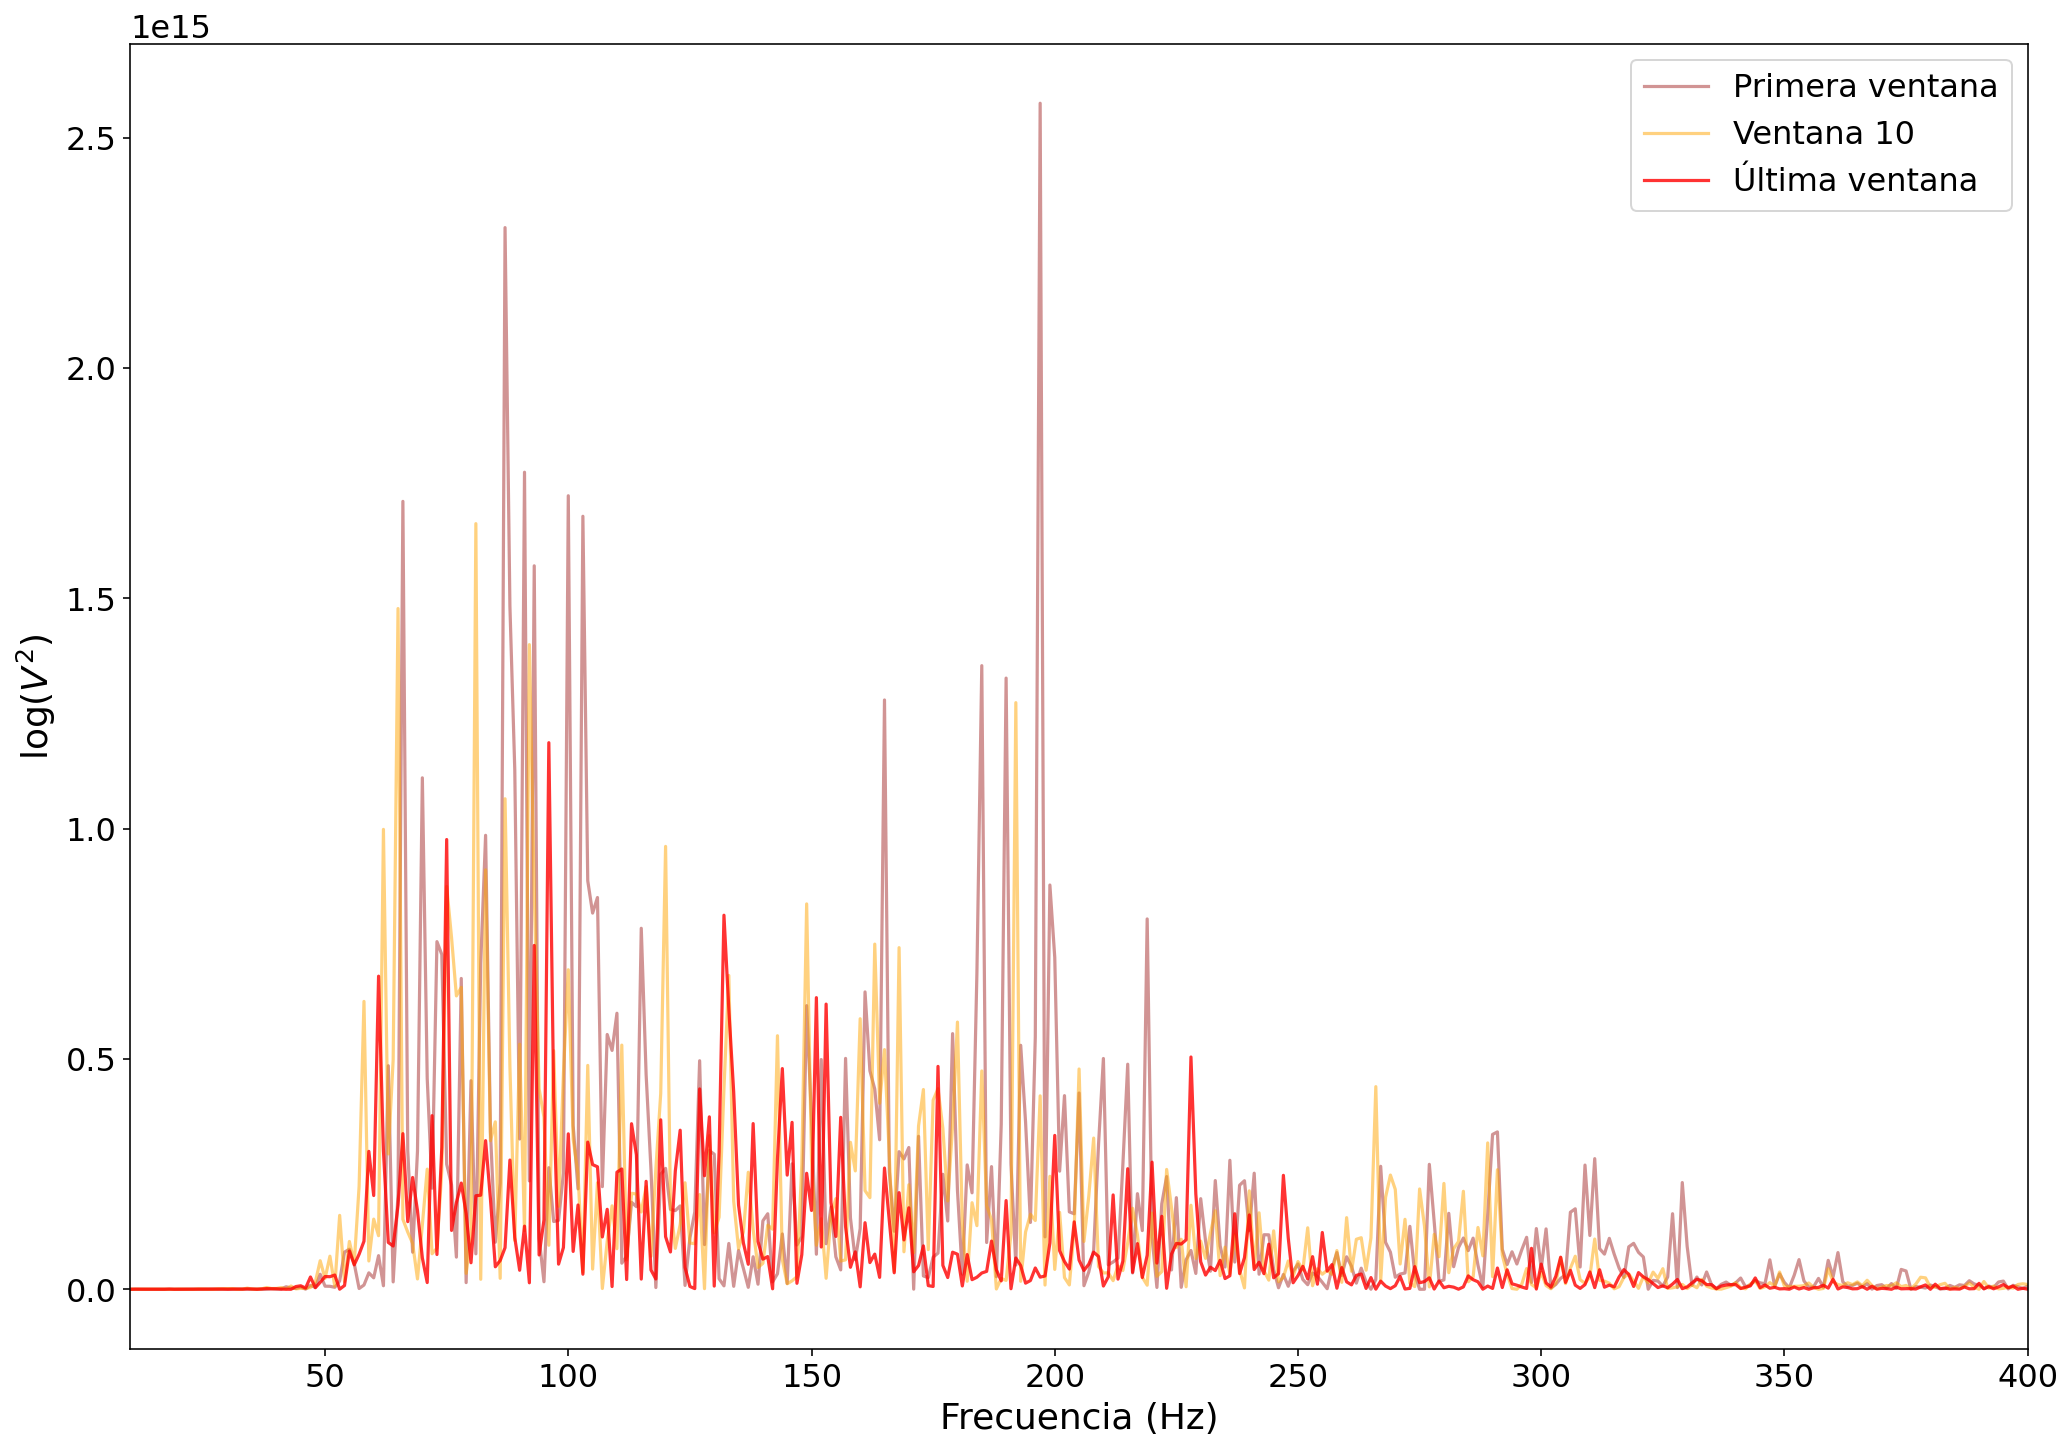

In [15]:
fig = plt.figure(figsize=(17,12))

ax = plt.subplot(111)
ax.plot(PSD(windowedEMG[0])[0],
        PSD(windowedEMG[0])[1],
        label='Primera ventana',alpha=.5,color='brown')

ax.plot(PSD(windowedEMG[10])[0],
        PSD(windowedEMG[10])[1],
        label='Ventana 10',alpha=.5, color='orange')

ax.plot(PSD(windowedEMG[-1])[0],
        PSD(windowedEMG[-1])[1],
        label='Última ventana',alpha=.8, color='red')

plt.xlim(10,400)
plt.legend()
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('log($V^2$)'); 

Utilizando la función  de la densidad espectral de potencia (PSD), también podemos calcular las frecuencias de potencia media y mediana, que se ha demostrado que cambian con la fatiga muscular.

In [16]:
#Frecuencia de potencia media.
def meanPF(data):
    F,P = PSD(data)
    sumProd = sum([F[i]*P[i] for i in range(0,len(F))])
    sumPower = sum(P)
    meanPower = sumProd/sumPower    
    return(round(meanPower,5))

#Frecuencia de potencia mediana.
def medianPF(data):
    F,P = PSD(data)
    medianPower = sum(P)/2   
    return(round(medianPower,5))

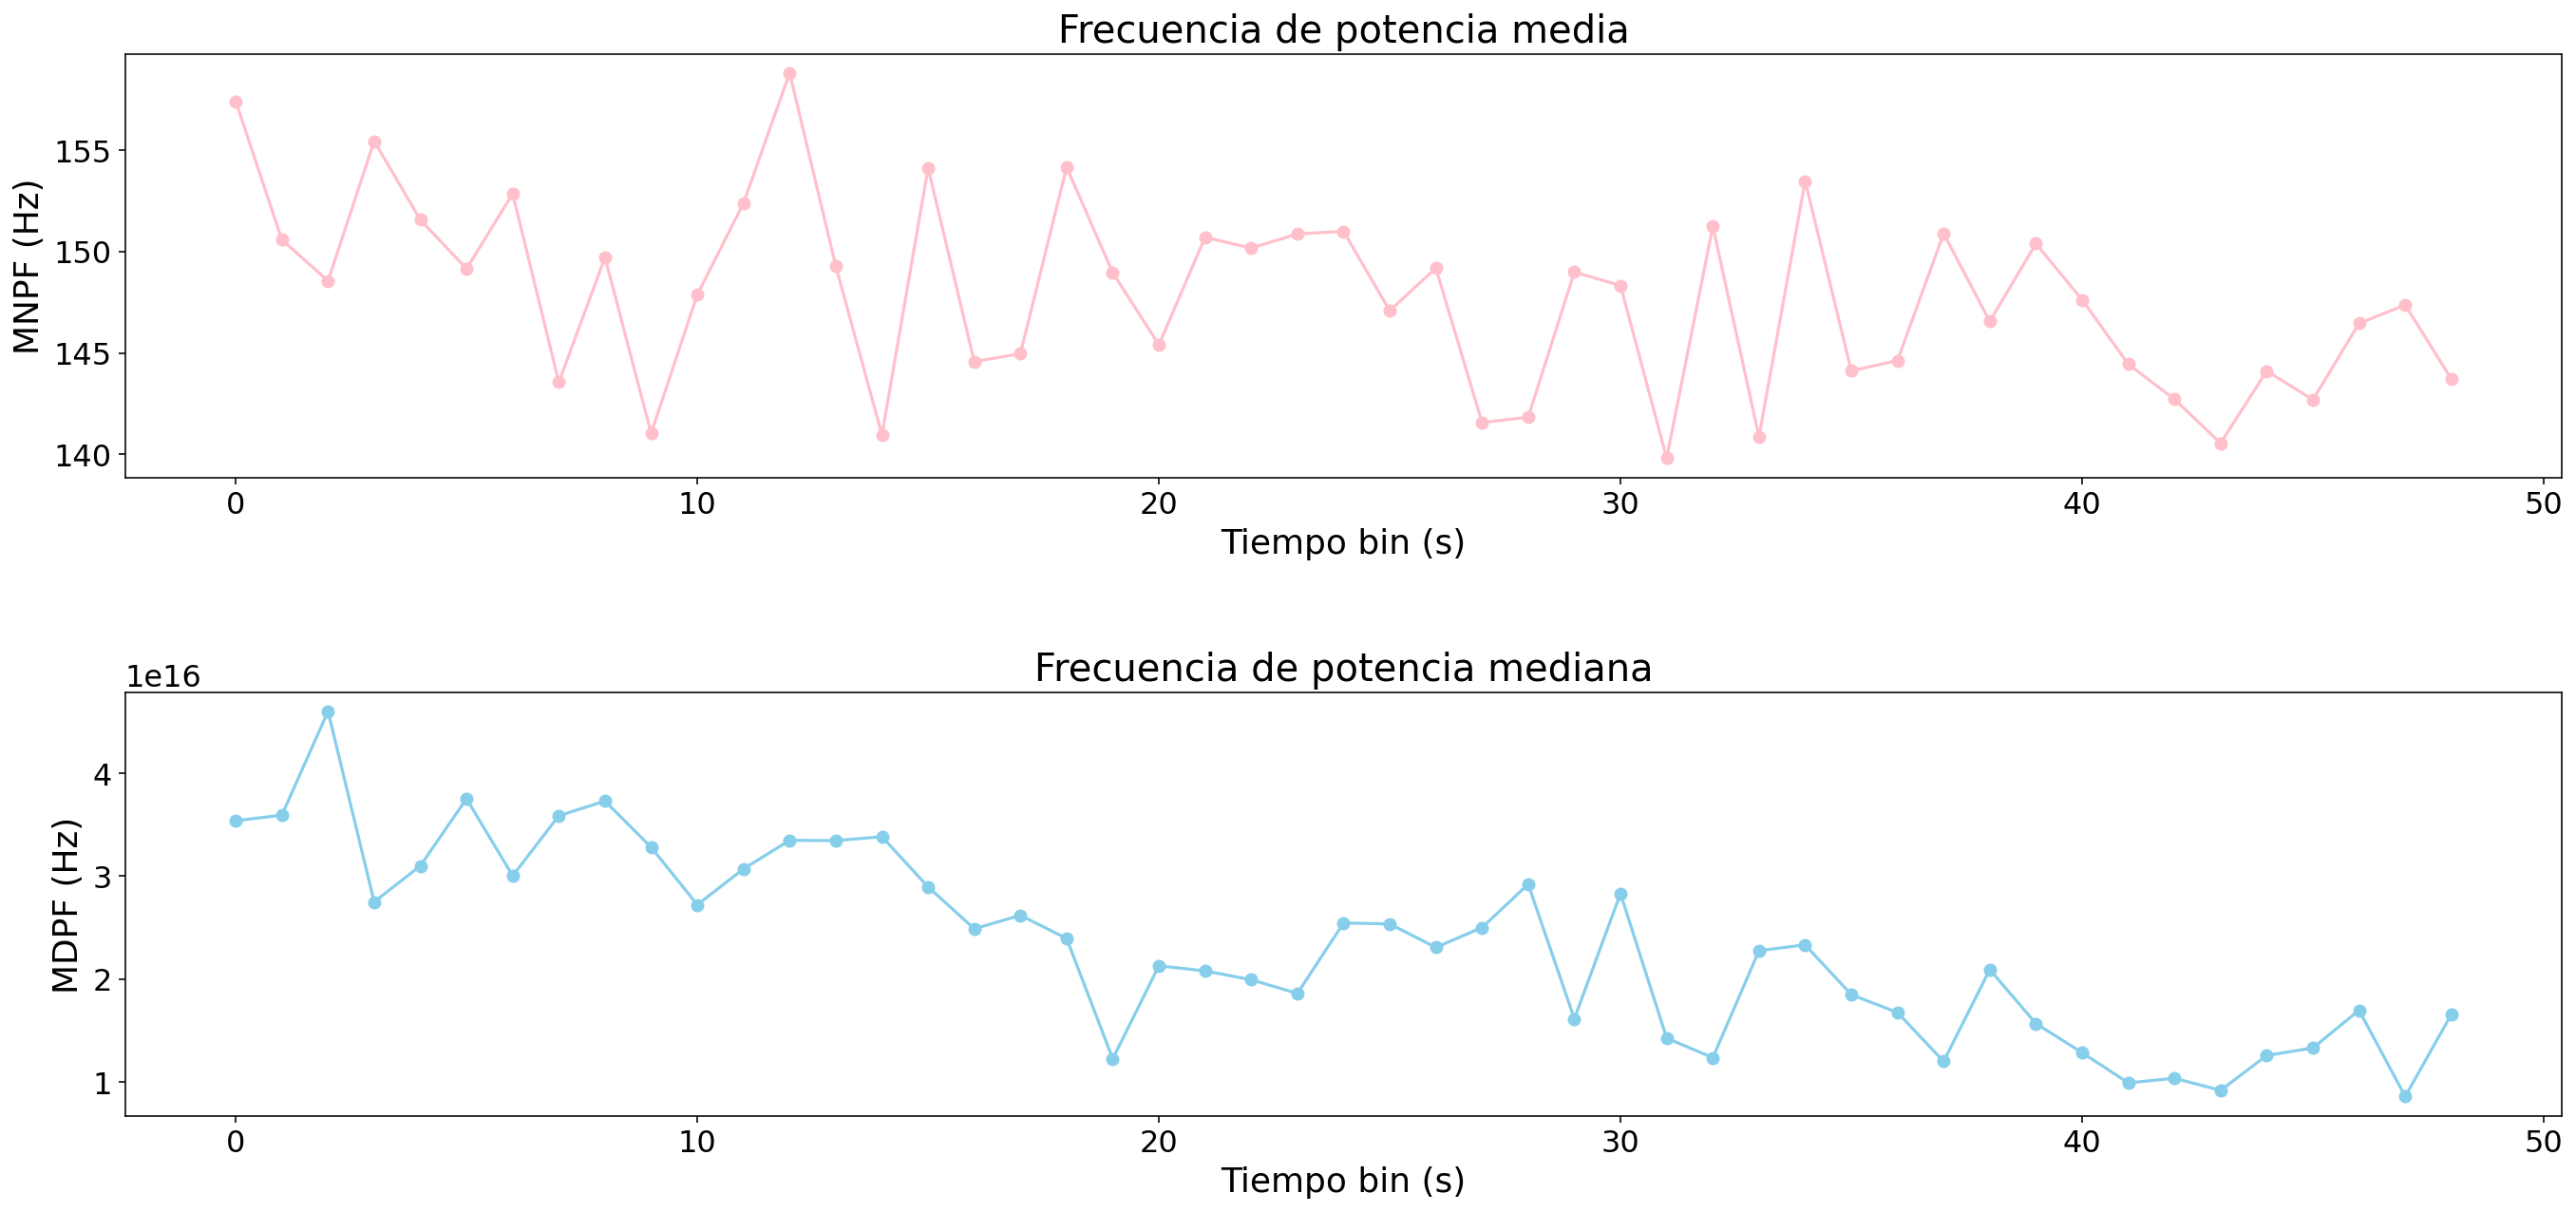

In [17]:
MNPF = list(map(meanPF,windowedEMG))
MDPF = list(map(medianPF,windowedEMG))

fig, (ax1,ax2) = plt.subplots(2,1,sharex=False,sharey=False,figsize = (20,10))

ax1.plot(MNPF,'o-',color='pink')
ax1.set_title('Frecuencia de potencia media')
ax1.set_ylabel('MNPF (Hz)')
ax1.set_xlabel('Tiempo bin (s)')

ax2.plot(MDPF,'o-',color='skyblue')
ax2.set_title('Frecuencia de potencia mediana')
plt.ylabel('MDPF (Hz)')
plt.xlabel('Tiempo bin (s)')

# Espaciado entre parcelas
plt.tight_layout(pad=3.0)

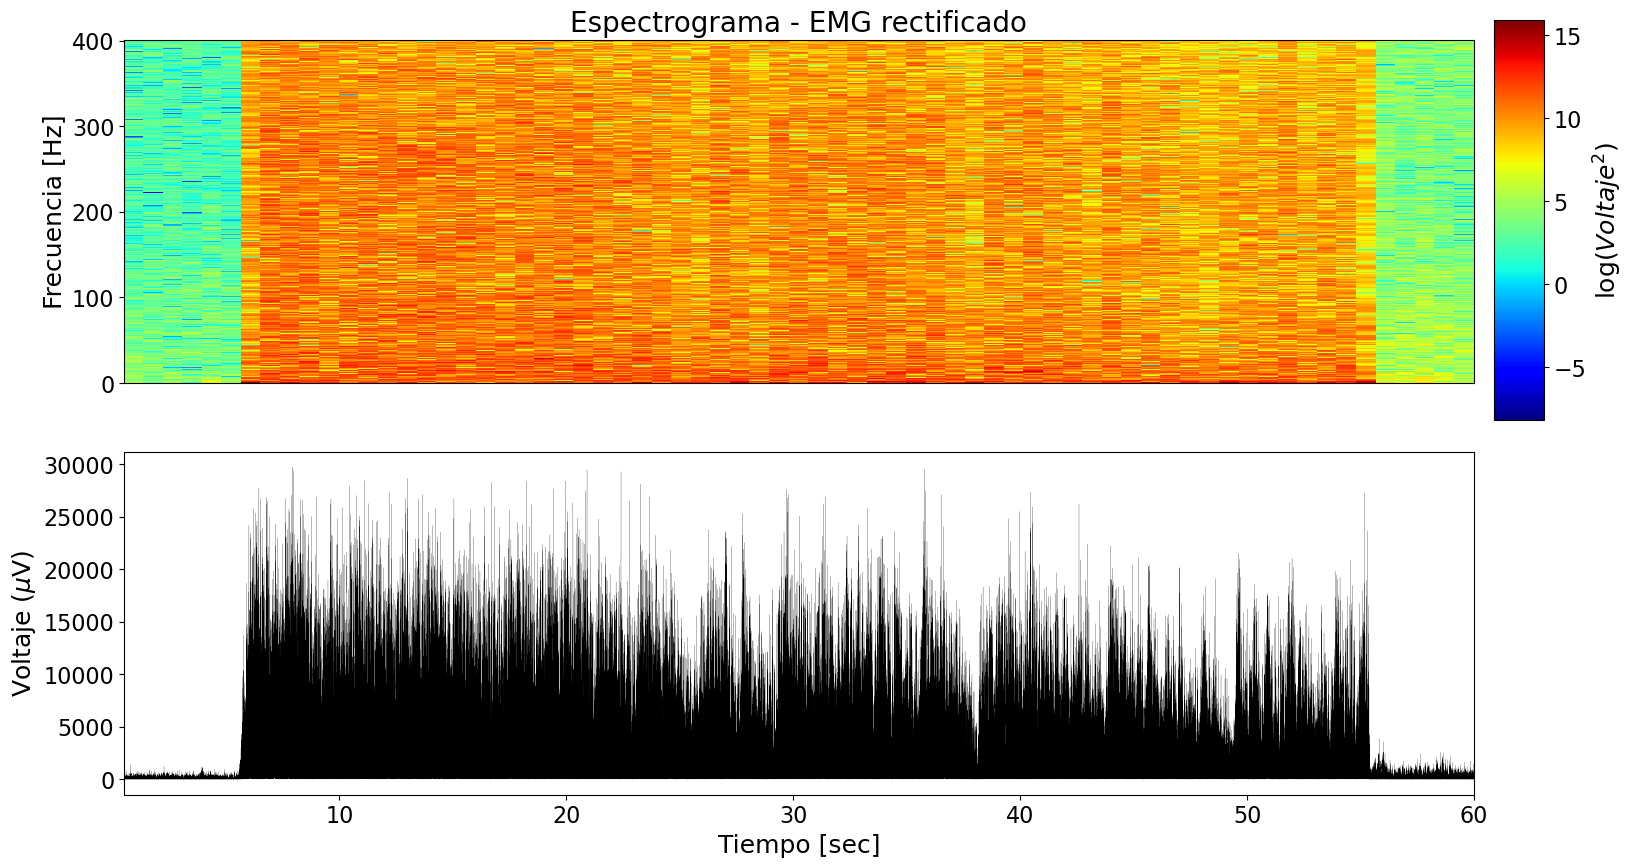

In [18]:
data = SeñalRelevante['AbsSeñal']
f,t,sxx = sc.signal.spectrogram(data,SeñalRelevante['FrecMuestreo'],nperseg=SeñalRelevante['FrecMuestreo'],\
                                scaling='spectrum')
f = f[:401]
sxx = sxx[:401]

#Tamaño de la figura.
fig = plt.figure(figsize=(20,10),dpi=50)

#Trazamos la señal rectificada.
ax2 = plt.subplot(212)
plt.plot(np.arange(0,len(data))/SeñalRelevante['FrecMuestreo'],data,lw=.1,color='black')
plt.ylabel('Voltaje ($\mu$V)')
plt.xlabel('Tiempo [sec]')
plt.xlim(t[0],t[-1])

#Trazamos el espectrograma con la señal rectificada. 
ax1 = plt.subplot(211)
plt.pcolormesh(np.log(sxx),cmap='jet')
plt.xticks([])
plt.ylabel('Frecuencia [Hz]')
plt.title('Espectrograma - EMG rectificado')

#Agregamos un eje independiente para la barra de colores.
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.81, .5, 0.025, 0.4])
plt.colorbar(label='log($Voltaje^2$)',cax=cbar_ax,)

plt.draw()

<a id='Fatigamuscularenlaspruebas'></a>
## Fatiga muscular en las pruebas

Los músculos también se fatigan con las contracciones repetidas. Les pedimos a los sujetos que repitieran el ejercicio anterior (sosteniendo un peso con el brazo doblado a 90 grados durante 50 segundos) durante 10 intentos con 60 segundos de descanso entre cada intento.

 La prueba 0, analizada anteriormente, es la primera prueba (es decir, antes de la fatiga a través de la repetición) y la prueba 9 es la última repetición, es decir, después de la fatiga.
En este apartado se mencionan diversas medidas que podríamos utilizar para cuantificar la fatiga. Uno es la “amplitud máxima” de la señal EMG,  si las pruebas repetidas fatigan el músculo, entonces la contracción máxima que generan los sujetos durante la prueba 9 debería ser menor que la generada durante la prueba 0, y veremos una disminución en la amplitud máxima. En segundo lugar, podemos calcular la  “raíz cuadrada media (RMS)“ de la señal, que también debería disminuir con la fatiga. Finalmente, calculamos el “área total” de la señal de la envolvente, es decir, el máximo de la suma acumulada, que también debería disminuir.

Primeramente, ejecutamos nuestra función de análisis en las pruebas 0 y 9, graficamos las dos grabaciones.

In [19]:
#Archivos para analizar
EMGr = ['../Registros/S3/concentric/S3_EMG_concentric_trial0.wav',
        '../Registros/S3/concentric/S3_EMG_concentric_trial9.wav']

In [20]:
#Generar una matriz vacía para almacenar datos.
data = []

#Iterar sobre cada grabación para analizar y graficar
for record in EMGr:
    SeñalRelevante =EMG(record,graph=0) 
    data.append(SeñalRelevante)

In [21]:
#Generación de matrices vacías para contener medidas.
maxsums = []
maxamps = []
rmss = []

# Utilizamos un loop para iterar sobre grabaciones.
for n in range(len(data)):
    
   #Calcular la amplitud máxima.
    maxamp=max(data[n]['AbsSeñal'])
    maxamps.append(maxamp)
    
    #Calcular la suma acumulada .
    sumSignal = np.cumsum(data[n]['AbsSeñal'])
    
    #Calcular el máximo de la suma acumulada, es decir, el área total.
    maxsum = max(sumSignal)
    maxsums.append(maxsum)
    
    #Calcular RMS
    rms=np.sqrt(np.mean(data[n]['AbsSeñal']**2))
    rmss.append(rms)

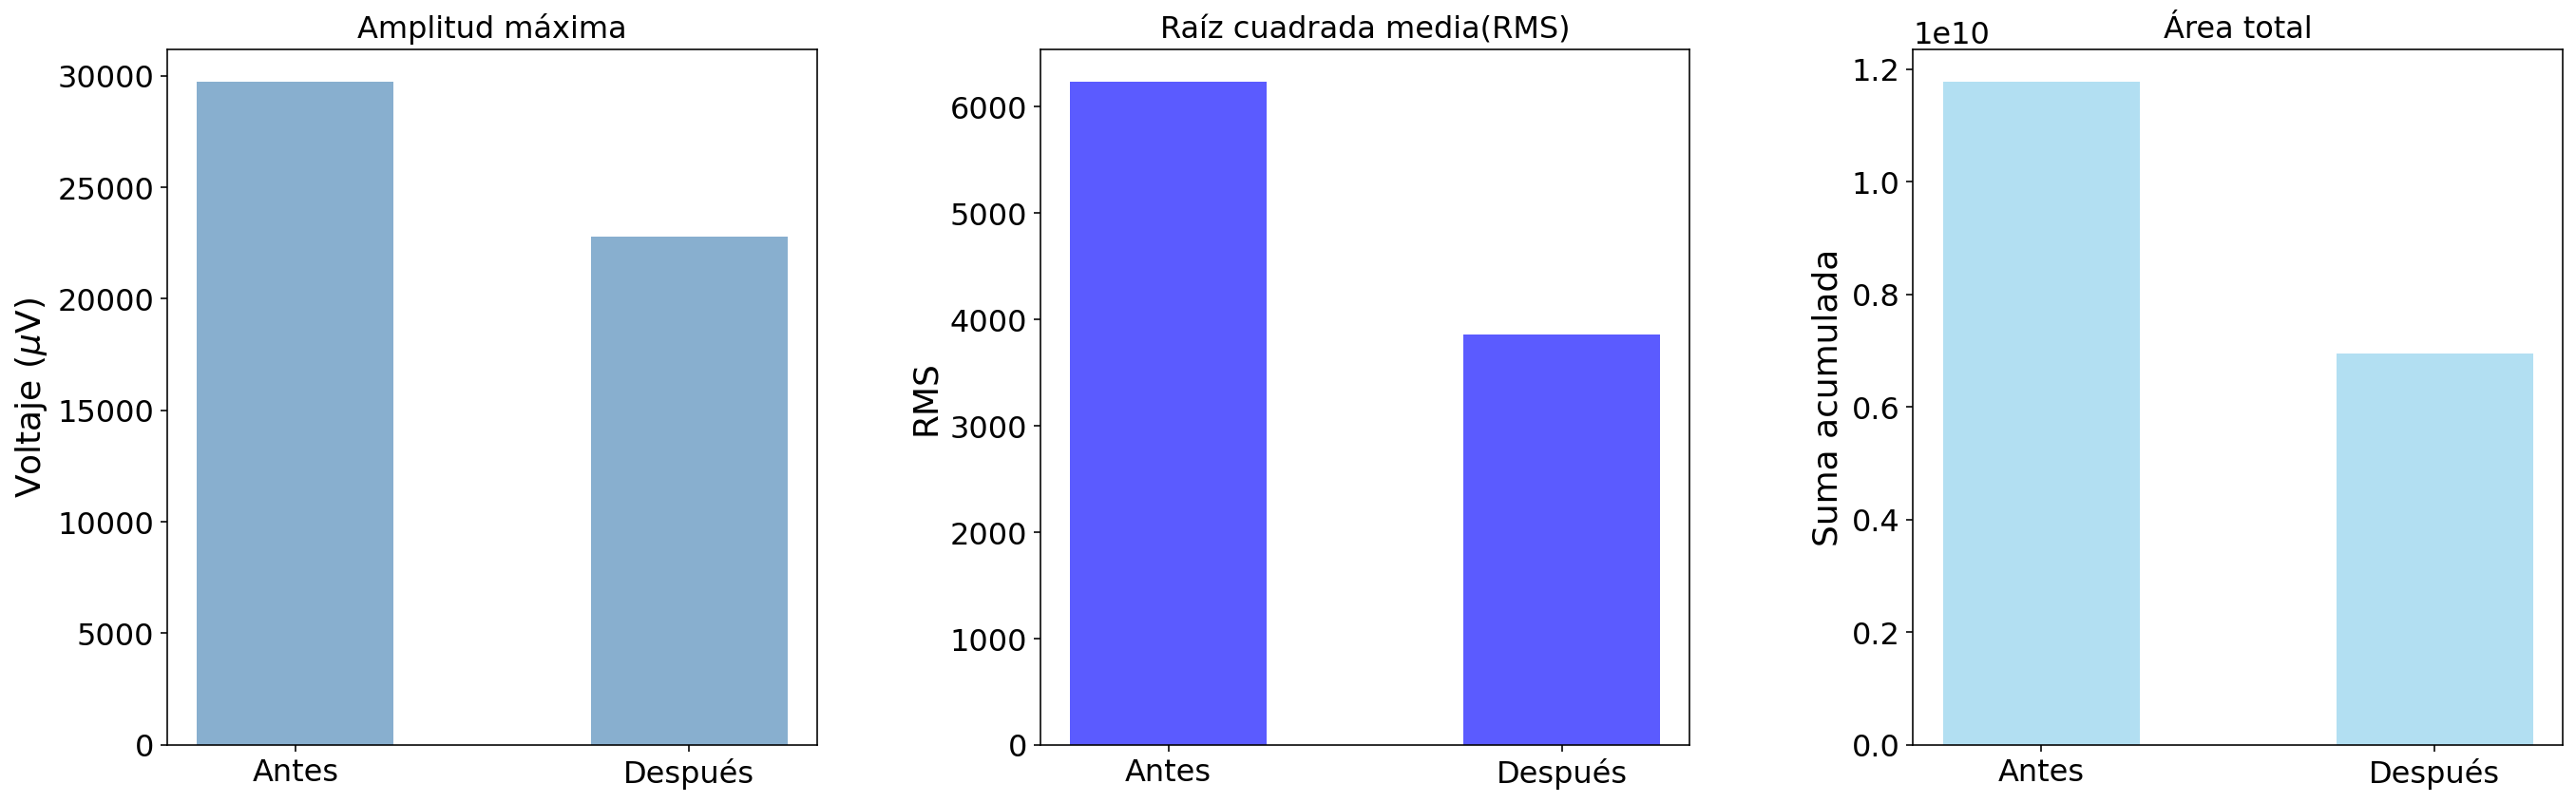

In [22]:
#Etiquetas para cada gráfico de barras.
labels = ('Antes','Después')
y_pos = [0,1]

plt.figure(figsize=(20,7)) 

#Graficar y comparar las amplitudes máximas.
plt.subplot(1, 3, 1)
for n in range(len(maxamps)):
    plt.bar(y_pos,maxamps,width=0.5,align='center',color='steelblue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('Amplitud máxima',fontsize=16)
    plt.ylabel('Voltaje ($\mu$V)')

#Graficar y comparar RMS
plt.subplot(1, 3, 2)
for n in range(len(rmss)):
    plt.bar(y_pos,rmss,width=0.5,align='center',color='blue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('Raíz cuadrada media(RMS)',fontsize=16)
    plt.ylabel('RMS')

#Graficar y comparar el área total
plt.subplot(1, 3, 3)
for n in range(len(maxsums)):
    plt.bar(y_pos,maxsums,width=0.5,align='center',color='skyblue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('Área total',fontsize=16)
    plt.ylabel('Suma acumulada')

# Espaciado entre ventanas
plt.tight_layout(pad=3.0)

Podemos ver que para las tres medidas, hay una disminución notable cuando comparamos la primera con la última prueba, lo que indica que el protocolo de contracciones repetidas indujo fatiga en el músculo bíceps.

Para conocer cómo cambió cada registro en todo el protocolo, podemos ejecutar el análisis en todos los ensayos y graficar las medidas como funciones del número de ensayo. Para hacer esto, primero definimos funciones que extraerán todos los nombres de archivo de un directorio dado y ordenarán los archivos para el procesamiento por lotes.

In [23]:
# loop sobre el directorio dado para extraer los nombres de los archivos.
def loopFiles(path):
    trials=[]
    for filename in os.listdir(path):
        if filename.endswith(".wav"): 
            file=os.path.join(path,filename)
            trials.append(file)
    return(trials)

filelist = loopFiles('../Registros/S4/concentric/')

#Ordenar archivos para que el análisis se ejecute en orden desde la prueba 0 hasta la prueba 9.
def lastchars(x):
    return(x[-5:])

dataset = sorted(filelist, key = lastchars)   

#Imprimir nombres de archivos en orden.
for elem in dataset:
    print(elem)

../Registros/S4/concentric/S4_EMG_concentric_trial0.wav
../Registros/S4/concentric/S4_EMG_concentric_trial1.wav
../Registros/S4/concentric/S4_EMG_concentric_trial2.wav
../Registros/S4/concentric/S4_EMG_concentric_trial3.wav
../Registros/S4/concentric/S4_EMG_concentric_trial4.wav
../Registros/S4/concentric/S4_EMG_concentric_trial5.wav
../Registros/S4/concentric/S4_EMG_concentric_trial6.wav
../Registros/S4/concentric/S4_EMG_concentric_trial7.wav
../Registros/S4/concentric/S4_EMG_concentric_trial8.wav
../Registros/S4/concentric/S4_EMG_concentric_trial9.wav


In [24]:
def batch(files):
    
    #Generar una matriz vacía para almacenar datos.
    data = []

    #Iterar sobre cada grabación para analizar y graficar
    for record in files:
        SeñalRelevante =EMG(record,graph=0)
        data.append(SeñalRelevante)
    
        
   #Generar matrices vacías para contener medidas.
    maxsums = []
    maxamps = []
    rmss = []
    
    # Utilizamos un loop para iterar sobre grabaciones.
    for n in range(len(data)):
        
        #Calcular la amplitud máxima 
        maxamp=max(data[n]['AbsSeñal'])
        maxamps.append(maxamp)
        
        #Calcular la suma acumulada.
        sumSignal = np.cumsum(data[n]['AbsSeñal'])
        
        #Calcular el máximo de la suma acumulada, es decir, el área total.
        maxsum = max(sumSignal)
        maxsums.append(maxsum)
        
       #Calcular RMS.
        rms=np.sqrt(np.mean(data[n]['AbsSeñal']**2))
        rmss.append(rms)
        
    #Graficar y comparar medidas en todos los ensayos.
    plt.figure(figsize=(20,7)) 

    #Graficar las amplitudes máximas.
    plt.subplot(1, 3, 1)
    plt.plot(maxamps,'o-', color='gold')
    plt.xticks(np.arange(0, 10, step=1))
    plt.xlabel('Prueba')
    plt.title('Amplitud máxima')

    #Graficar RMS.
    plt.subplot(1, 3, 2)
    plt.plot(rmss,'o-',color='orange');
    plt.xticks(np.arange(0, 10, step=1))
    plt.xlabel('Prueba')
    plt.title('Raíz cuadrada media (RMS)')

    #Área total de la ventana
    plt.subplot(1, 3, 3)
    plt.plot(maxsums,'o-',color='red')
    plt.xticks(np.arange(0, 10, step=1))
    plt.xlabel('Prueba')
    plt.title('Área total')

    # Espaciado entre ventanas
    plt.tight_layout(pad=3.0)
 
    return

Realizamos un análisis sobre cualquier tema simplemente cambiando el directorio (S1, S2, etc.)

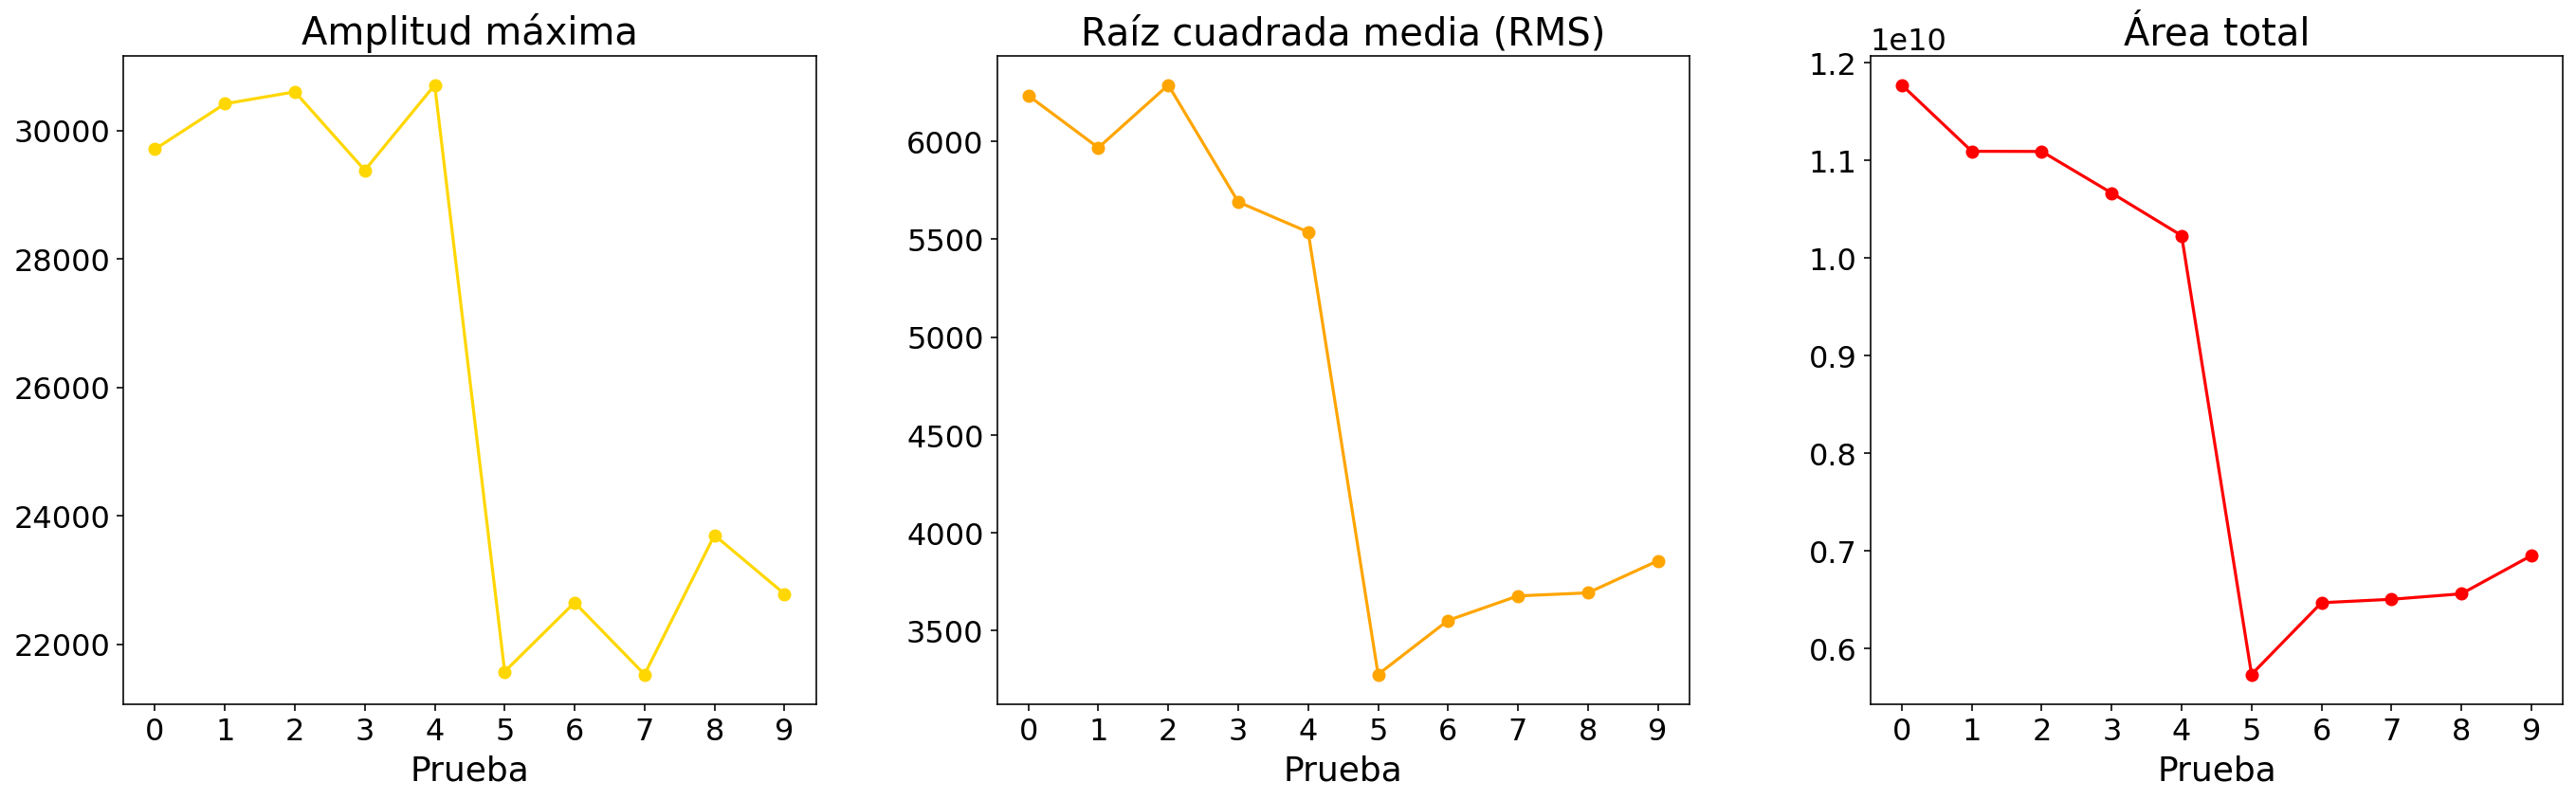

In [25]:
filelist = loopFiles('../Registros/S3/concentric/')
dataset = sorted(filelist, key = lastchars)
batch(files=dataset) 

Realizar un análisis de frecuencia en varios archivos.

In [26]:
filelist = loopFiles('../Registros/S3/concentric/')
dataset = sorted(filelist, key = lastchars)

#Generar una matriz vacía para almacenar datos.
data = []

#Iterar sobre cada grabación para analizar y graficar
for record in dataset:
    SeñalRelevante =EMG(record,graph=0)
    data.append(SeñalRelevante)
    
#Creación de una matriz vacía para contener medidas
MDFs = []

# Usamos un loop para iterar sobre grabaciones
for n in range(len(data)):
    ovData = windows(data[n]['dataf'],data[n]['FrecMuestreo'],data[n]['FrecMuestreo'])
    MDF = list(map(medianPF,ovData))
    MDFs.append(MDF)

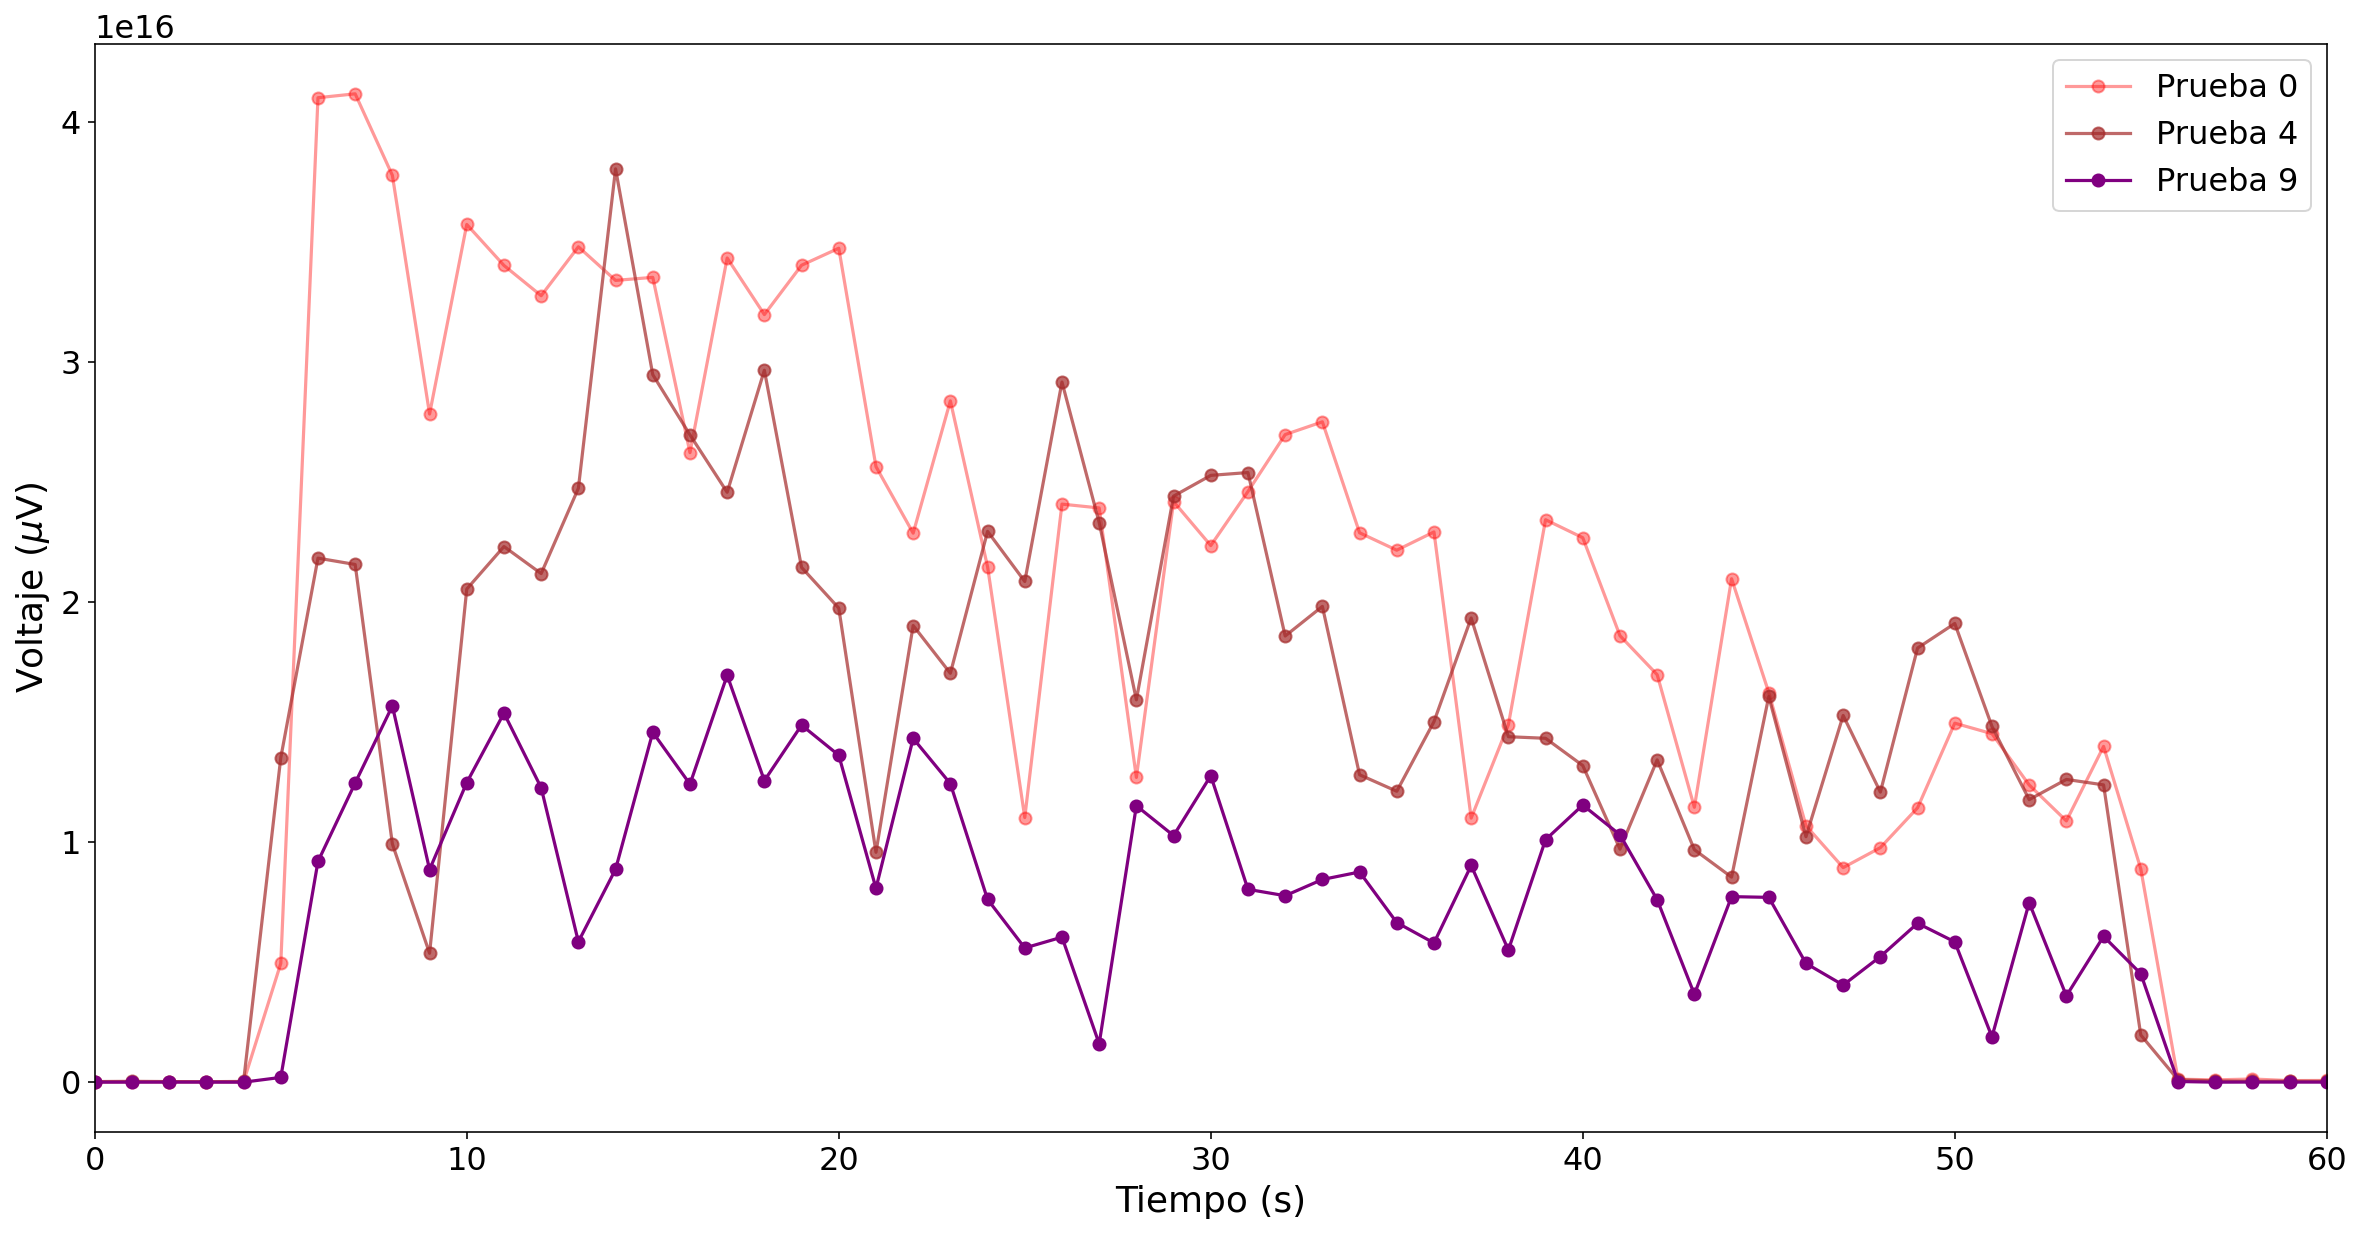

In [27]:
plt.figure(figsize=(20,10))
plt.plot(MDFs[0],'o-',label='Prueba 0',alpha=0.4,color='red')
plt.plot(MDFs[4],'o-',label='Prueba 4',alpha=0.7,color='brown')
plt.plot(MDFs[9],'o-',label='Prueba 9',color='purple')
plt.xlabel('Tiempo (s)')
plt.ylabel(r'Voltaje ($\mu$V)')
plt.xlim(0,60)
plt.legend();

In [28]:
# suprimir el diseño ajustado
import warnings
warnings.filterwarnings('ignore')

In [ ]:
Prueba0=EMG(archivo='../Registros/S3/concentric/S3_EMG_concentric_trial0.wav',graph=0)
Prueba9=EMG(archivo='../Registros/S3/concentric/S3_EMG_concentric_trial9.wav',graph=0)

fig = plt.figure(figsize=(20,10),dpi=100)

data = Prueba0['AbsSeñal']
f, t, sxx1 = sc.signal.spectrogram(data,Prueba0['FrecMuestreo'],nperseg=Prueba0['FrecMuestreo'],\
                                   scaling='spectrum')
f = f[:401]
sxx1 = sxx1[:401]
min_sxx1 = np.min(np.log(sxx1))
max_sxx1 = np.max(np.log(sxx1))

plt.subplot(211)
plt.pcolormesh(np.log(sxx1),cmap='jet',vmin=min_sxx1,vmax=max_sxx1)
plt.ylabel('Frecuencia [Hz]')
plt.title('Espectrograma - Prueba 0')

data =  Prueba9['AbsSeñal']
f, t, sxx = sc.signal.spectrogram(data,Prueba9['FrecMuestreo'],nperseg=Prueba9['FrecMuestreo'],\
                                   scaling='spectrum')
f = f[:401]
f = f[:401]
sxx = sxx[:401]
plt.subplot(212)
plt.pcolormesh(np.log(sxx),cmap='jet',vmin=min_sxx1,vmax=max_sxx1)
plt.ylabel('Frecuencia [Hz]')
plt.title('Espectrograma - Prueba 9')
plt.xlabel('Tiempo [s]')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, .1, 0.035, 0.8])
plt.colorbar(label='log($Voltaje^2$)',cax=cbar_ax,)

plt.draw()
plt.tight_layout()

De las cifras anteriores, podemos ver que el primer espectrograma alcanza valores más altos asociados con el contenido de energía por frecuencia (área naranja). Esto se puede observar a lo largo de toda la banda de frecuencia (0-400 Hz). 

El segundo espectrograma muestra una disminución generalizada del contenido de potencia aportado por la frecuencia. Es posible comparar rápidamente estos gráficos al notar la diferencia en los colores generales del espectograma, con el primer espectograma mostrando tonos más cercanos al rojo (valores de potencia más altos), mientras que el segundo muestra un color amarillo general (valores de potencia más bajos)


## Referencias

Registros y Notebook recuperado del repositorio elaborado por la Dra.Erin C. McKiernan, Noel Isaías Plascencia Díaz, Mitsui Myrna Salgado Saito, Ana Daniela del Río Pulido, consultado en:
https://github.com/emckiernan/electrophys

Este trabajo fue apoyado por UNAM-DGAPA-PAPIME PE213817 y PE213219.